In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import gc

from sklearn import set_config
from sklearn.base import clone
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
#from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from prophet import Prophet

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

import ruptures as rpt

from statsmodels.tsa.seasonal import seasonal_decompose

import os
for dirname, _, filenames in os.walk('C:/Users/tomas/Documents/GitHub/Adaptative_Ensemble_methods_for_time_series_forecast/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:/Users/tomas/Documents/GitHub/Adaptative_Ensemble_methods_for_time_series_forecast/data\Times_Series_Project_uoc.xlsx


In [2]:
#!pip install xgboost

Data loading

In [3]:
PATH_FILE = 'C:/Users/tomas/Documents/GitHub/Adaptative_Ensemble_methods_for_time_series_forecast/data/Times_Series_Project_uoc.xlsx'

Others_Europe = pd.read_excel(PATH_FILE, 'Others_Europe')
Continental_Europe2 = pd.read_excel(PATH_FILE, 'Continental_Europe2')
Continental_Europe = pd.read_excel(PATH_FILE, 'Continental_Europe')
Latam = pd.read_excel(PATH_FILE, 'Latam')
Central_Europe = pd.read_excel(PATH_FILE, 'Central_Europe')
Asia = pd.read_excel(PATH_FILE, 'Asia')

Let's see some rows

In [4]:
Continental_Europe.head(10)

,date,sales_city1,sales_city2,sales_city3,humidity_avg_Brussels,humidity_avg_Gent,humidity_avg_Liege,temp_avg_k_Brussels,temp_avg_k_Gent,temp_avg_k_Liege,...,gtrends_BE-VLG_hooikoorts,gtrends_BE-VLG_pollen,gtrends_BE-VLG_pollen allergie,gtrends_BE-WAL_allegra,gtrends_BE-WAL_allergie,gtrends_BE-WAL_allergies,gtrends_BE-WAL_hooikoorts,gtrends_BE-WAL_pollen,gtrends_BE-WAL_pollen allergie,influenza
0,2020-01-06,40.475836,230.963619,103.344398,87.444762,87.446429,81.805495,278.220690,278.526250,278.083278,...,1,7,5,0,27,10,0,7,5,14.0
1,2020-01-13,39.694071,212.956826,100.096151,87.723901,85.797619,87.474567,281.354858,281.468929,281.071925,...,1,7,8,0,25,6,0,3,0,16.0
2,2020-01-20,38.009519,223.776538,99.269312,82.875000,82.791667,82.373571,279.799524,279.827083,279.962374,...,1,5,0,0,25,15,0,8,10,36.0
3,2020-01-27,43.201567,230.590213,103.475563,92.231429,91.488095,89.290000,276.271436,276.677798,276.095924,...,3,6,0,0,22,6,0,10,15,38.0
4,2020-02-03,41.311220,235.200285,105.087095,84.169560,81.571429,84.876725,281.821402,281.804167,281.931171,...,0,5,5,18,29,18,0,18,0,32.0
5,2020-02-10,38.590584,233.140921,101.974618,80.092619,79.077381,78.315934,279.507990,279.836845,279.437056,...,2,8,0,21,23,20,0,11,6,37.0
6,2020-02-17,40.881466,237.620631,105.615497,74.863095,73.529762,76.095238,281.242083,281.299048,280.958988,...,2,10,0,57,23,16,21,13,0,0.0
7,2020-02-24,40.457835,213.161826,104.232923,80.900869,79.208333,81.330848,280.927214,281.082798,280.768137,...,3,9,0,26,27,7,0,10,5,33.0
8,2020-03-02,47.324099,269.131155,120.669392,82.188645,80.392857,83.840952,278.580197,278.743988,278.585237,...,1,8,0,0,26,23,0,6,0,22.0
9,2020-03-09,52.922852,277.803901,129.423389,85.066590,82.910714,84.414626,279.560366,279.727560,279.650940,...,4,10,9,0,21,29,0,9,9,0.0


In [5]:
print('We have ', Central_Europe.shape[0], ' rows and ', Central_Europe.shape[1], 'columns in the Central_Europe Dataset.')
print('We have ', Others_Europe.shape[0], ' rows and ', Others_Europe.shape[1], 'columns in the Others_Europe Dataset.')
print('We have ', Continental_Europe.shape[0], ' rows and ', Continental_Europe.shape[1], 'columns in the Continental_Europe Dataset.')
print('We have ', Continental_Europe2.shape[0], ' rows and ', Continental_Europe2.shape[1], 'columns in the Continental_Europe2 Dataset.')
print('We have ', Latam.shape[0], ' rows and ', Latam.shape[1], 'columns in the Latam Dataset.')
print('We have ', Asia.shape[0], ' rows and ', Asia.shape[1], 'columns in the Asia Dataset.')

We have  174  rows and  150 columns in the Central_Europe Dataset.
We have  183  rows and  66 columns in the Others_Europe Dataset.
We have  186  rows and  34 columns in the Continental_Europe Dataset.
We have  186  rows and  132 columns in the Continental_Europe2 Dataset.
We have  189  rows and  111 columns in the Latam Dataset.
We have  174  rows and  221 columns in the Asia Dataset.


Define the Dataframe we want to analyze, we are going to use Continental_Europe dataframe

In [6]:
df_study = Continental_Europe

Let's see number on NAs by column in the numerical ones

In [7]:
na_count = df_study.isna().sum()

columns_with_na = na_count[na_count > 0]

print(columns_with_na)

Series([], dtype: int64)


We can see we have no NAs

Miramos la correlación entre las distintas variables regresoras y la variable target, las variables con bajo valor absoluto de correlación con la variable objetivo pueden ser eliminadas.

In [8]:
df_study.drop(['date', 'sales_city1', 'sales_city2', 'sales_city3'], axis=1).apply(lambda x: x.corr(df_study.sales_city1))

humidity_avg_Brussels               -0.520247
humidity_avg_Gent                   -0.508681
humidity_avg_Liege                  -0.478859
temp_avg_k_Brussels                  0.311041
temp_avg_k_Gent                      0.296778
temp_avg_k_Liege                     0.304111
gtrends_BE_allegra                   0.593742
gtrends_BE_allergie                  0.897693
gtrends_BE_allergie symptomen        0.500999
gtrends_BE_allergies                 0.853979
gtrends_BE_hooikoorts                0.957024
gtrends_BE_pollen                    0.953246
gtrends_BE-BRU_allergie              0.725402
gtrends_BE-BRU_allergie symptomen   -0.000581
gtrends_BE-BRU_allergies             0.507530
gtrends_BE-BRU_hooikoorts            0.525146
gtrends_BE-BRU_pollen                0.865778
gtrends_BE-VLG_allegra               0.541824
gtrends_BE-VLG_allergie              0.867313
gtrends_BE-VLG_allergies             0.497677
gtrends_BE-VLG_hooikoorts            0.957523
gtrends_BE-VLG_pollen             

Seeing this we can think about dropping 'gtrends_BE-BRU_allergie symptomen'

### Now we see correlation between variables, if the correlation is close to 1 or -1 we could think about dropping one variable.

In [9]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df_study.iloc[:,1:], 20))

Top Absolute Correlations
temp_avg_k_Brussels        temp_avg_k_Gent              0.998698
                           temp_avg_k_Liege             0.998397
gtrends_BE_hooikoorts      gtrends_BE-VLG_hooikoorts    0.996227
temp_avg_k_Gent            temp_avg_k_Liege             0.996173
gtrends_BE_pollen          gtrends_BE-VLG_pollen        0.982877
sales_city1                sales_city2                  0.979451
                           sales_city3                  0.975520
gtrends_BE_allergie        gtrends_BE-VLG_allergie      0.970294
humidity_avg_Brussels      humidity_avg_Liege           0.969794
sales_city2                sales_city3                  0.968128
gtrends_BE_pollen          gtrends_BE-VLG_hooikoorts    0.961434
gtrends_BE_hooikoorts      gtrends_BE_pollen            0.960375
sales_city1                gtrends_BE-VLG_hooikoorts    0.957523
                           gtrends_BE_hooikoorts        0.957024
gtrends_BE_pollen          gtrends_BE-WAL_pollen        0.956838

Now we are going to remove some highly correlated variables, to avoid redundant info, we are going to keep the variable most correlated with the target.

## REVISAR ESTA PARTE!!


In [10]:
vars_drop = ['gtrends_BE-BRU_allergie symptomen',
'temp_avg_k_Gent',
'temp_avg_k_Liege',
'sales_city2',
'sales_city3',
'gtrends_BE-BRU_allergie',
'humidity_avg_Liege',
'gtrends_BE-VLG_hooikoorts',
'gtrends_BE-VLG_pollen',
'gtrends_BE-VLG_allergie',
'gtrends_BE-VLG_hooikoorts',
'gtrends_BE-WAL_pollen',
'gtrends_BE-WAL_allergie',
'humidity_avg_Gent',
'gtrends_BE-WAL_pollen allergie',
'gtrends_BE-VLG_pollen allergie',
'gtrends_BE-BRU_pollen',
'gtrends_BE-WAL_allergies']

df_study = df_study.drop(vars_drop, axis=1)

In [11]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(df_study.iloc[:,1:], 10))

Top Absolute Correlations
gtrends_BE_hooikoorts  gtrends_BE_pollen        0.960375
sales_city1            gtrends_BE_hooikoorts    0.957024
                       gtrends_BE_pollen        0.953246
gtrends_BE_allergie    gtrends_BE_pollen        0.928183
                       gtrends_BE_hooikoorts    0.902188
sales_city1            gtrends_BE_allergie      0.897693
gtrends_BE_allergies   gtrends_BE_pollen        0.883155
gtrends_BE_allergie    gtrends_BE_allergies     0.871590
sales_city1            gtrends_BE_allergies     0.853979
gtrends_BE_allergies   gtrends_BE_hooikoorts    0.853437
dtype: float64


In [12]:
df_study.shape

(186, 17)

<AxesSubplot:>

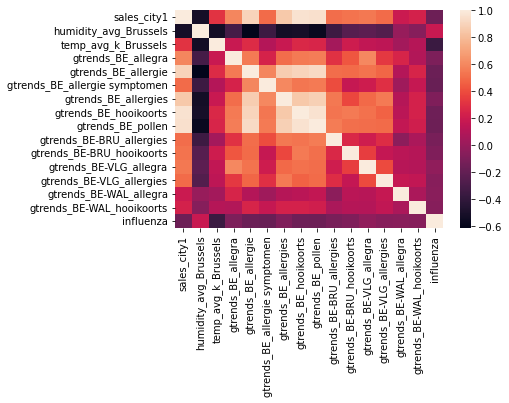

In [13]:
cols_vars = list(df_study.columns)[1:]

# calculate the correlation matrix on the numeric columns
corr = df_study[cols_vars].corr()

# plot the heatmap
sns.heatmap(corr)

Histogram of: sales_city1 



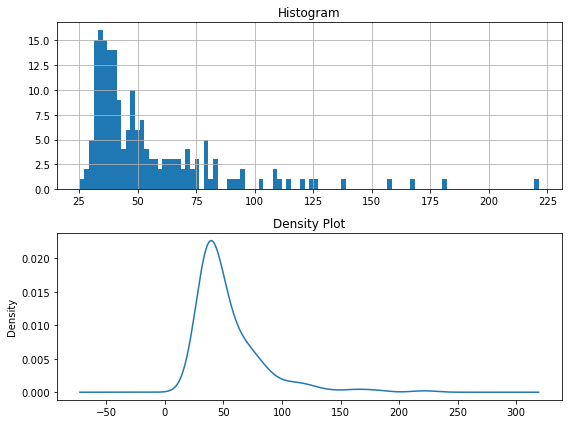

Histogram of: humidity_avg_Brussels 



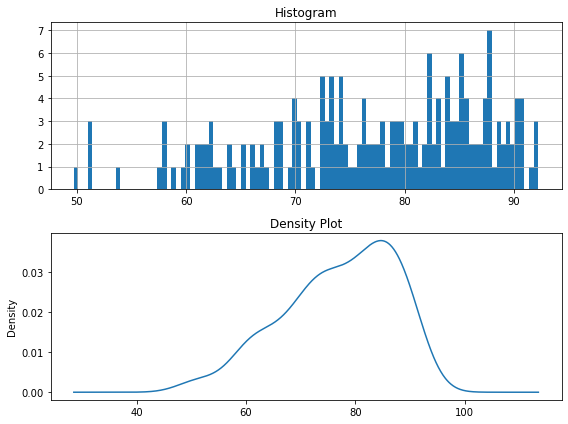

Histogram of: temp_avg_k_Brussels 



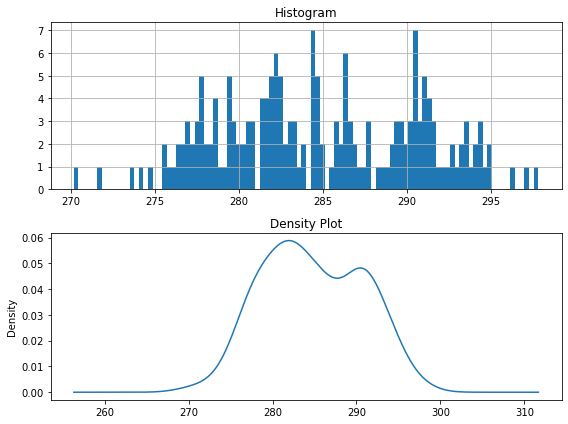

Histogram of: gtrends_BE_allegra 



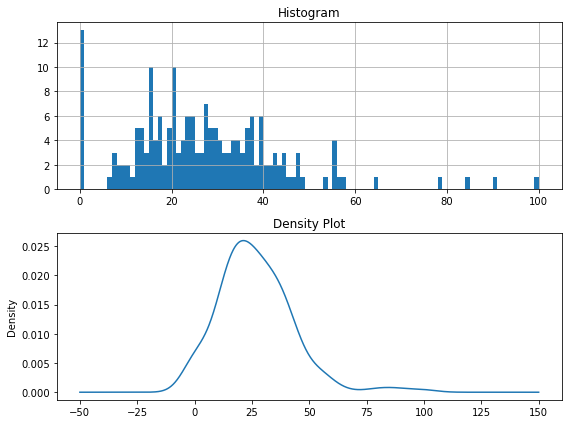

Histogram of: gtrends_BE_allergie 



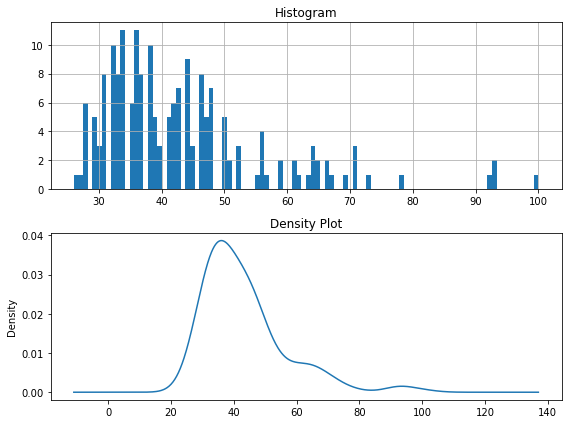

Histogram of: gtrends_BE_allergie symptomen 



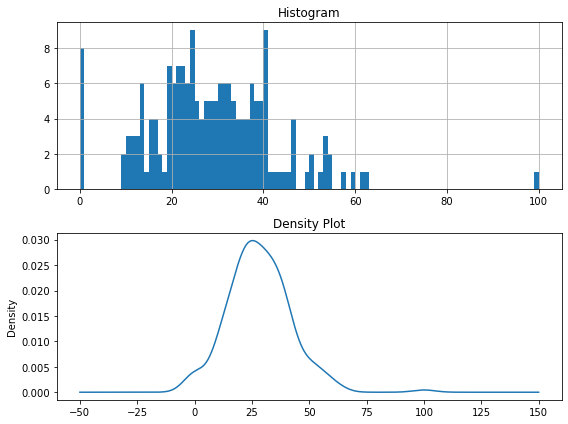

Histogram of: gtrends_BE_allergies 



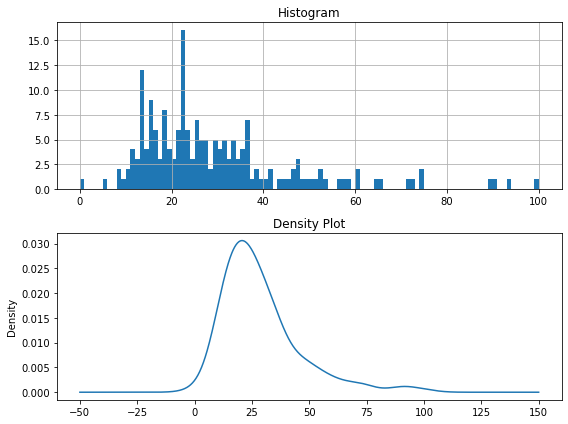

Histogram of: gtrends_BE_hooikoorts 



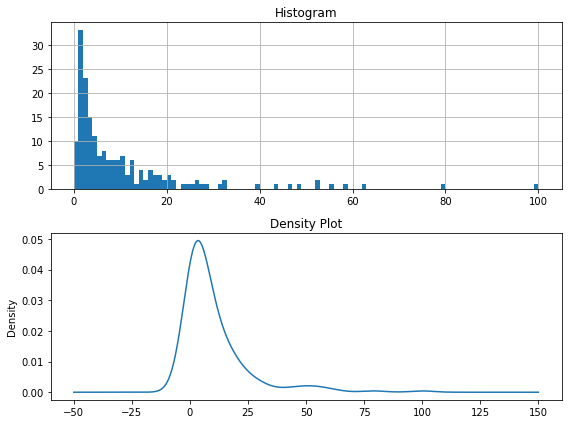

Histogram of: gtrends_BE_pollen 



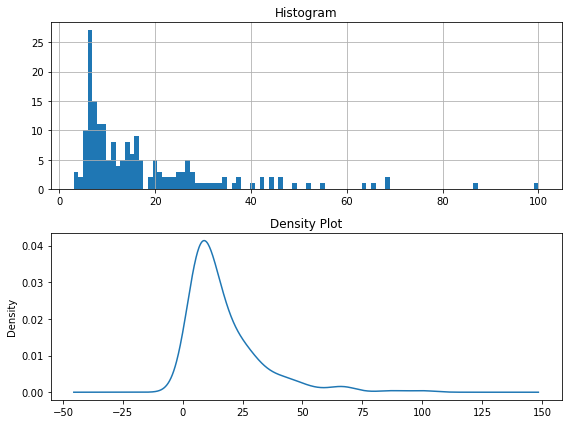

Histogram of: gtrends_BE-BRU_allergies 



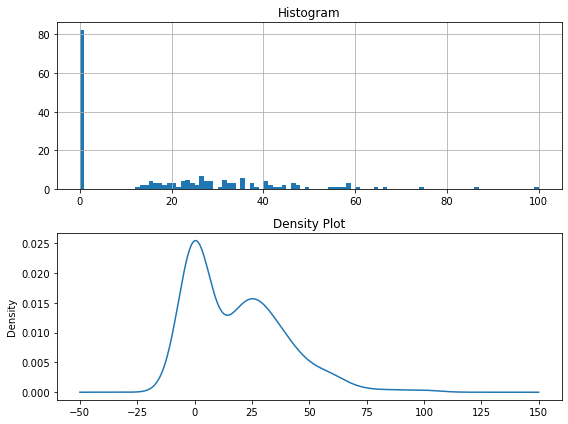

Histogram of: gtrends_BE-BRU_hooikoorts 



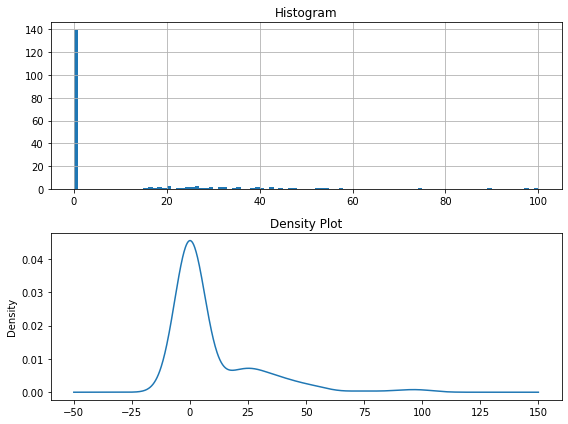

Histogram of: gtrends_BE-VLG_allegra 



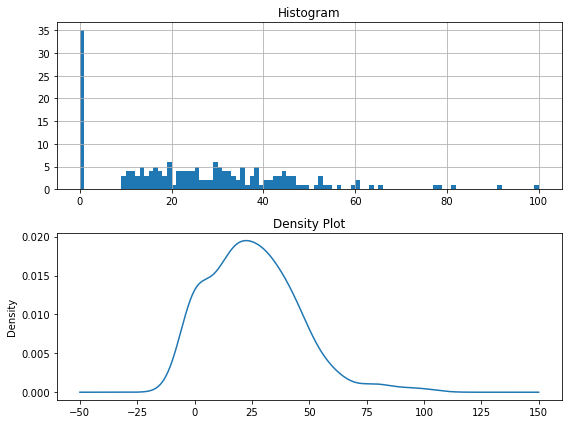

Histogram of: gtrends_BE-VLG_allergies 



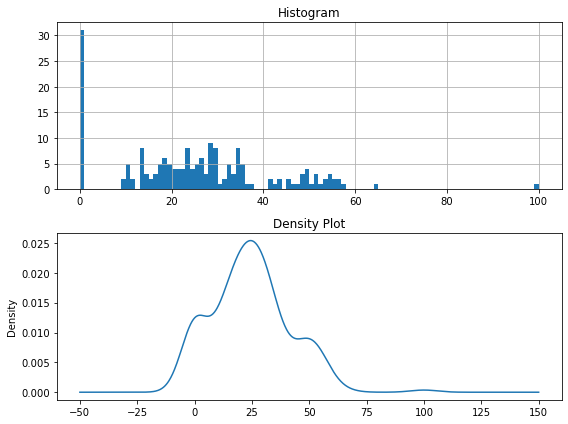

Histogram of: gtrends_BE-WAL_allegra 



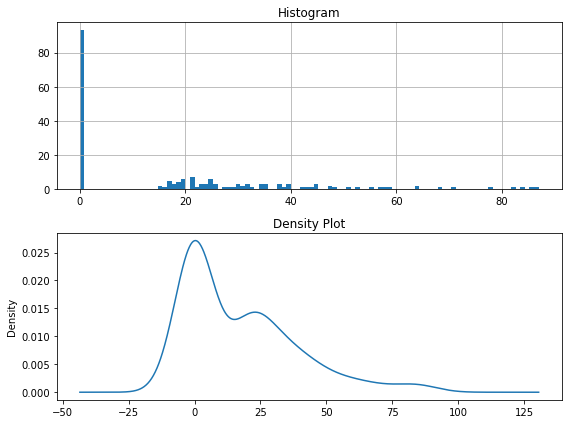

Histogram of: gtrends_BE-WAL_hooikoorts 



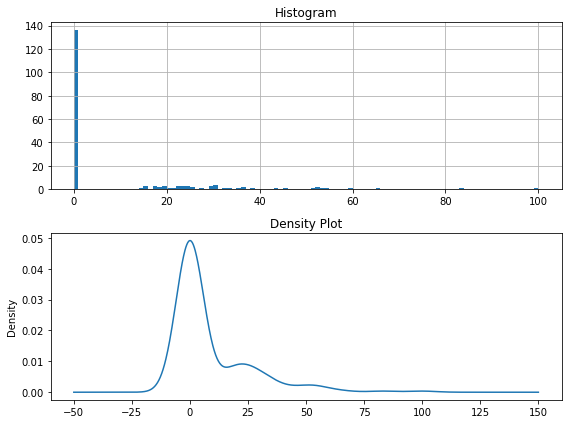

Histogram of: influenza 



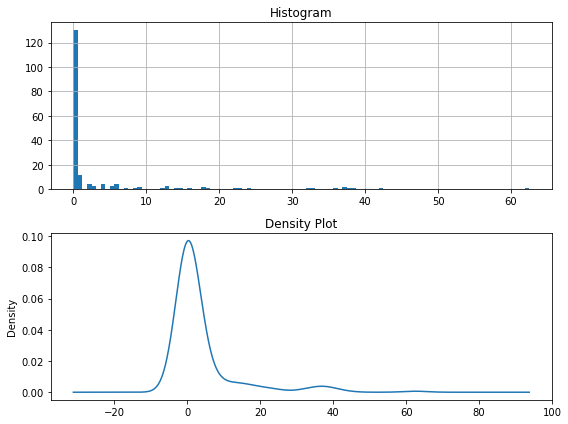

In [14]:
cols_vars = list(df_study.columns)[1:]


for col in cols_vars:
    print('Histogram of:', col, '\n')
    plt.figure(figsize=(8, 6))

    # Histograma
    plt.subplot(2, 1, 1)
    df_study[col].hist(bins=100)
    plt.title('Histogram')

    # Gráfico de densidad
    plt.subplot(2, 1, 2)
    df_study[col].plot(kind='density')
    plt.title('Density Plot')

    plt.tight_layout()
    plt.show()

Aquí tenemos los histogramas y gráficos de densidad por variable. 

Podemos ver por ejemplo que la mayoría de las ventas (variable target) se encuentran entre 25 y 50, formando una distribución similar a una chi cuadrado.

Podemos también ver algunos valores que podrían ser outliers, por ejemplo, valores cercanos a 100 en la variable gtrends_BE_pollen, este tipo de valores puede distorsionar las predicciones, así que probaremos a imputarlas para mejorar los resultados de los modelos.

### Gráficos de lineas de todas las variables

In [15]:
# Calcular el MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [16]:
tseries = {f"{x}": df_study.set_index("date")[x]for x in df_study.columns[1:]}

In [17]:
def ts_as_supervised(ts: pd.Series, n_lags: int) -> pd.DataFrame:
    ts_df = pd.concat([ts.shift(i) for i in range(n_lags, -1, -1)], axis=1)
    ts_df.columns = ['t-' + str(i) for i in list(reversed(range(n_lags)))[:-1]] + ['t', 't+1']
    ts_df['Date'] = ts.index.tolist()
    ts_df['Week'] = ts_df.Date.dt.isocalendar().week.astype("int")
    ts_df = ts_df.dropna().reset_index(drop=True).set_index("Date")
 
    return ts_df

training, testing, max_value = {}, {}, {}
for k, ts in tseries.items():
    # Using the last 6 months for testing
    train = ts[ts.index < '2023-07-3']
    test = ts[ts.index >= '2023-07-3']
 
    # Normalizing the data by the training mean value
    max_value[k] = train.max()
    train /= max_value[k]
    test /= max_value[k]
 
    # Time series to tabular format
    training[k] = training[k] = ts_as_supervised(train, 6)
    testing[k] = ts_as_supervised(test, 6)
    
train_df = pd.concat(training, axis=0)
test_df = pd.concat(testing, axis=0)

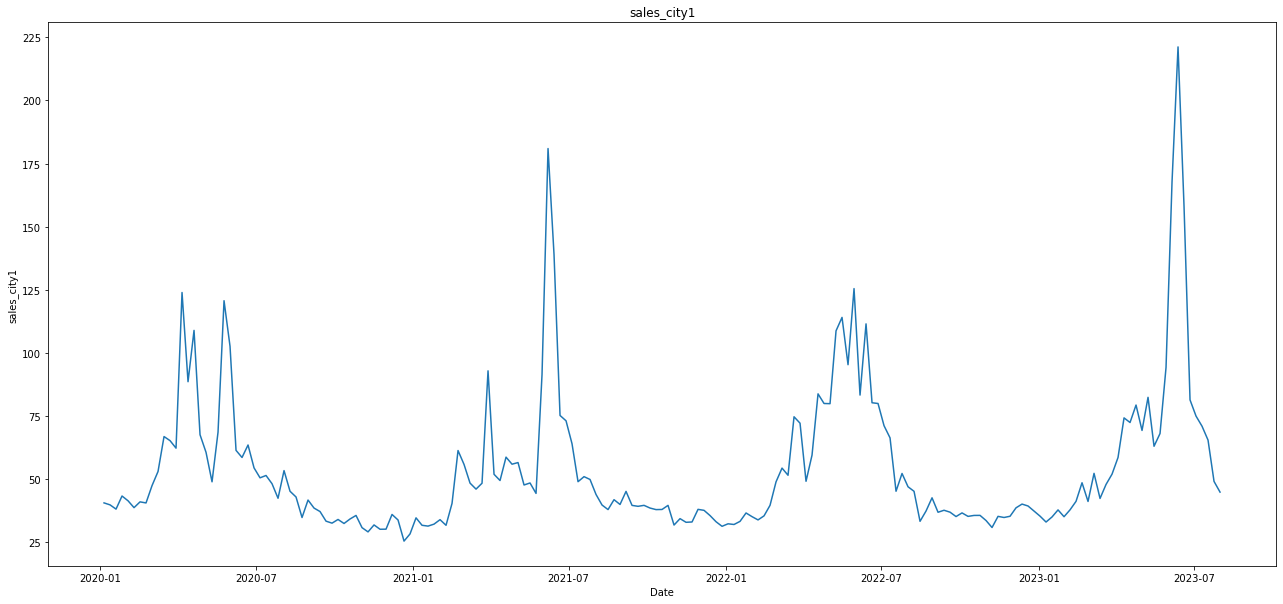

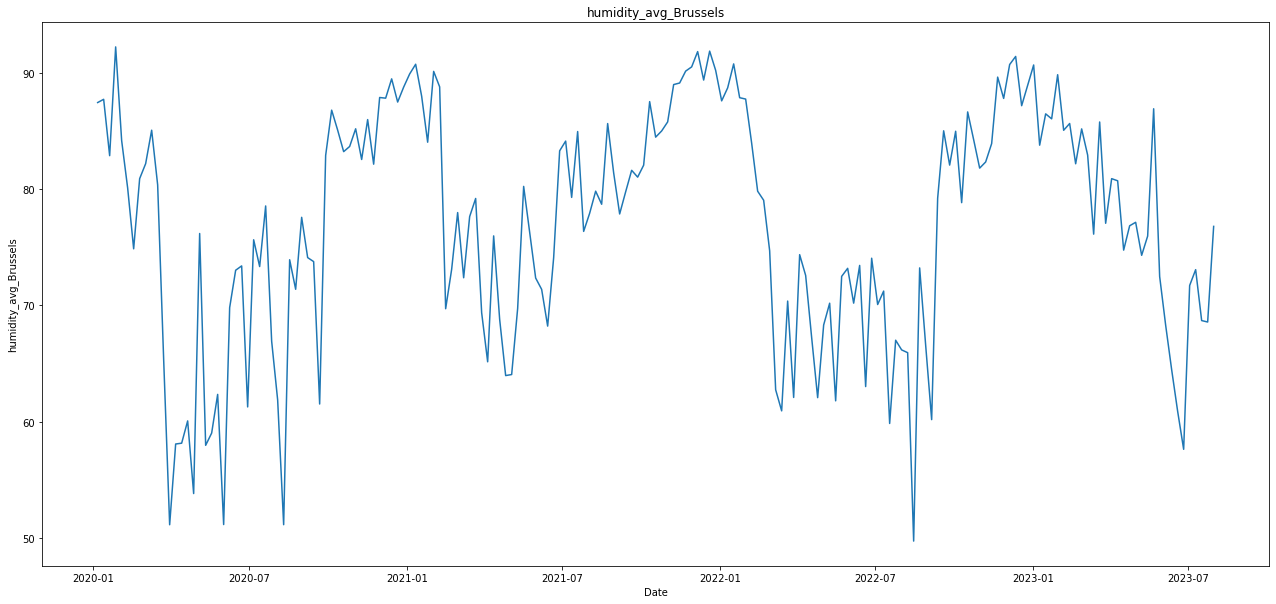

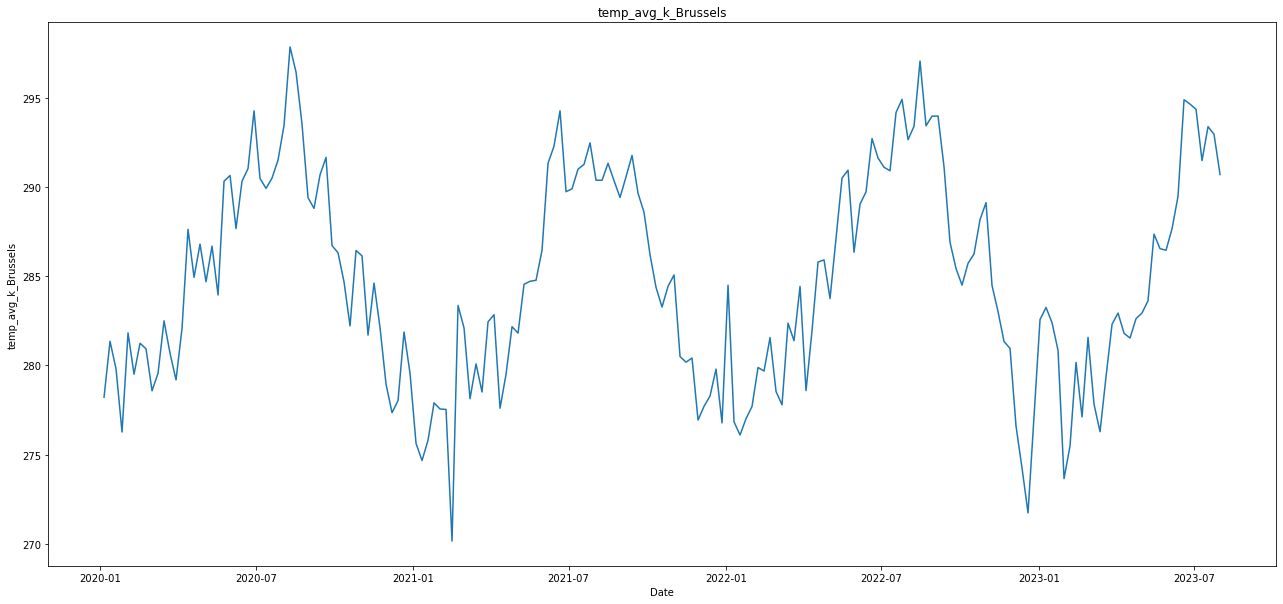

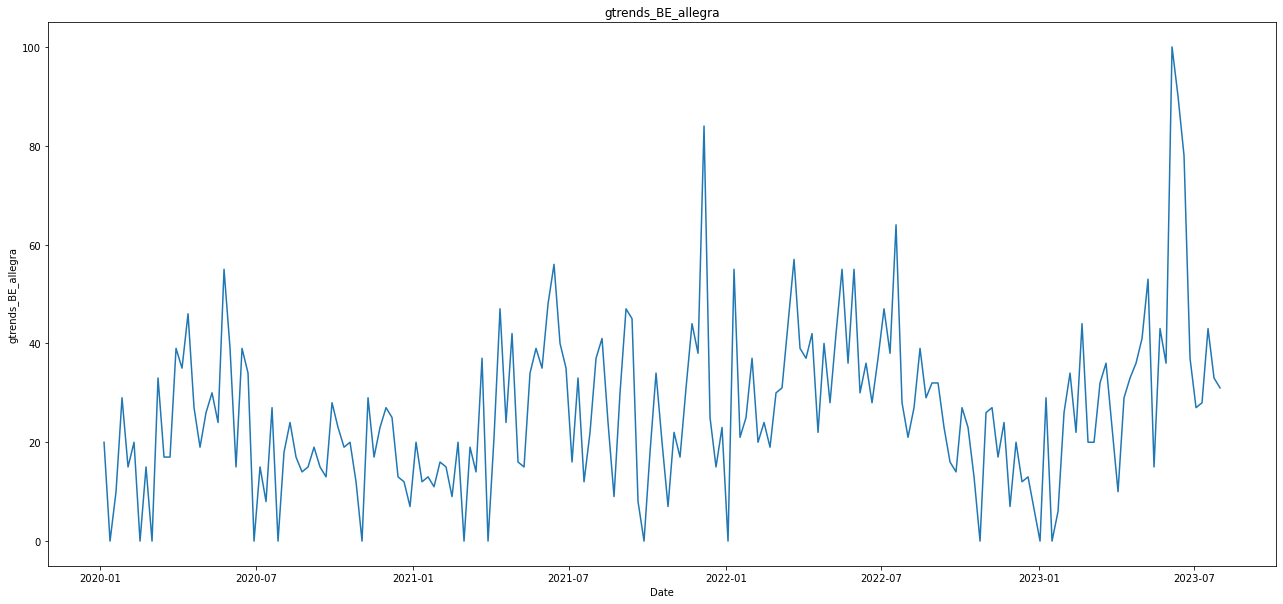

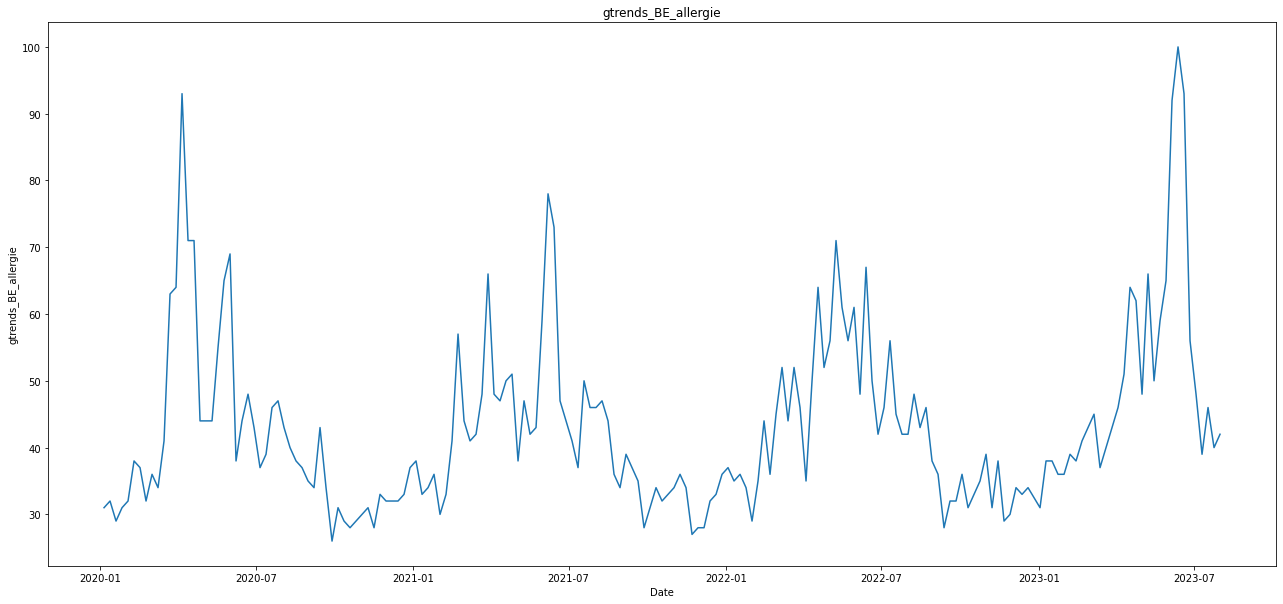

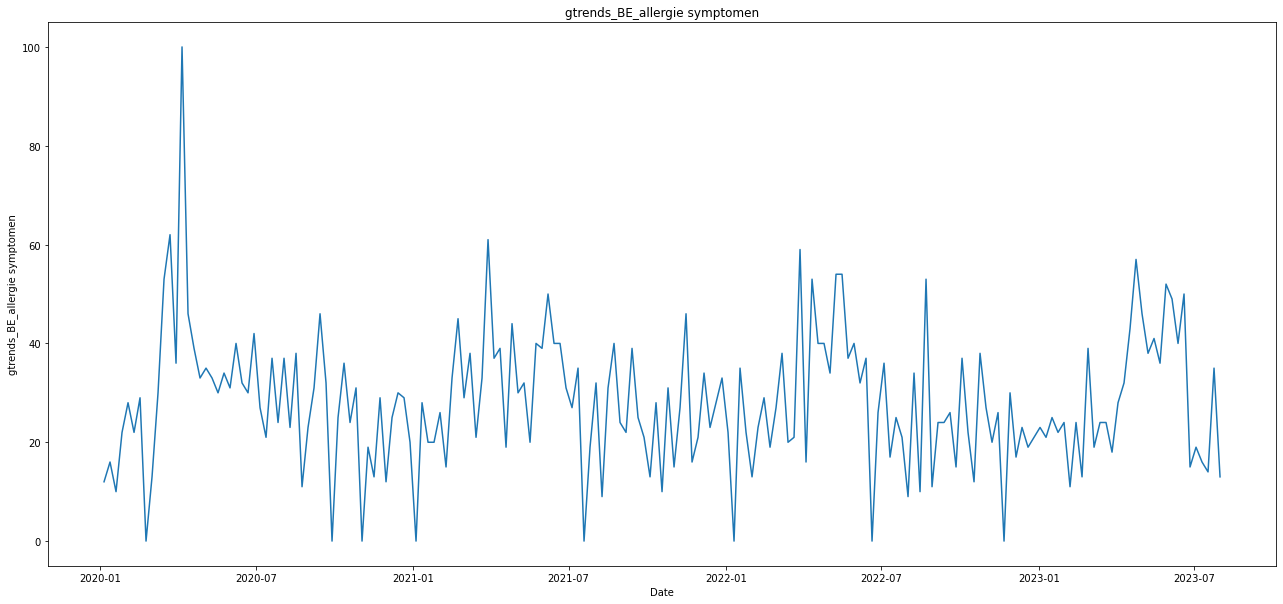

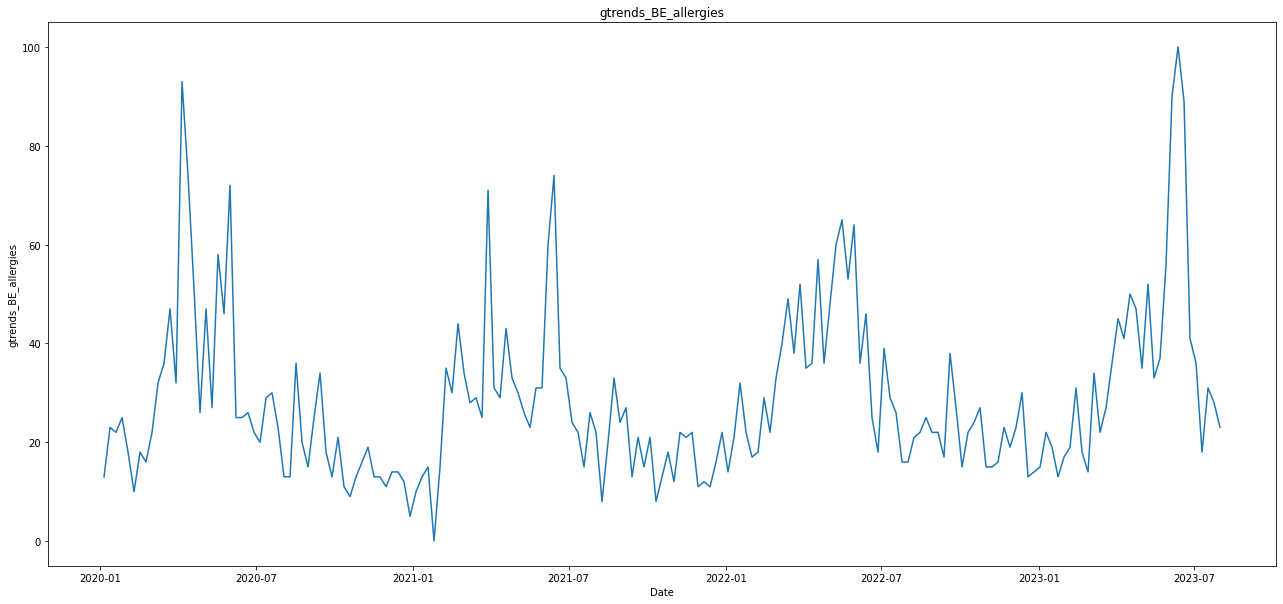

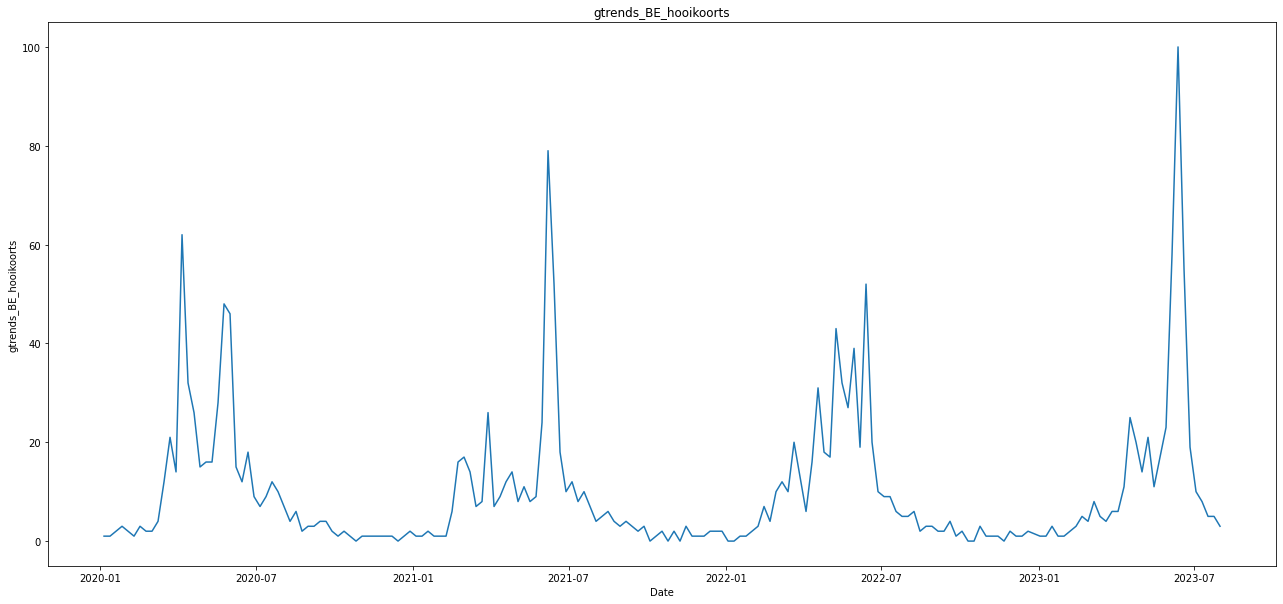

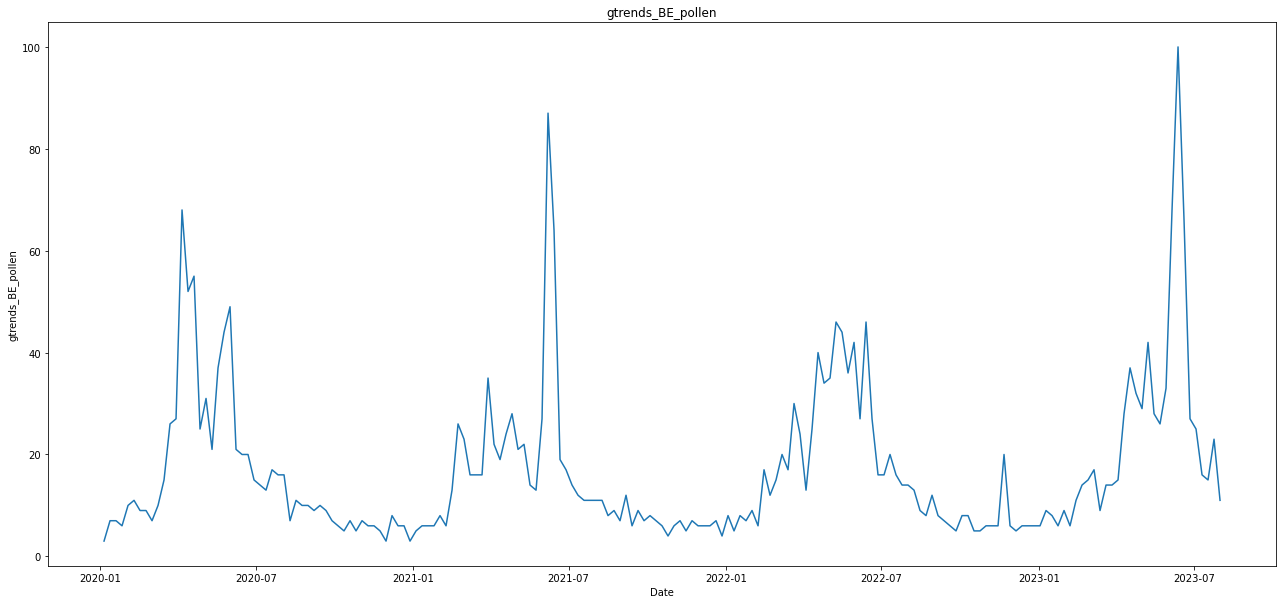

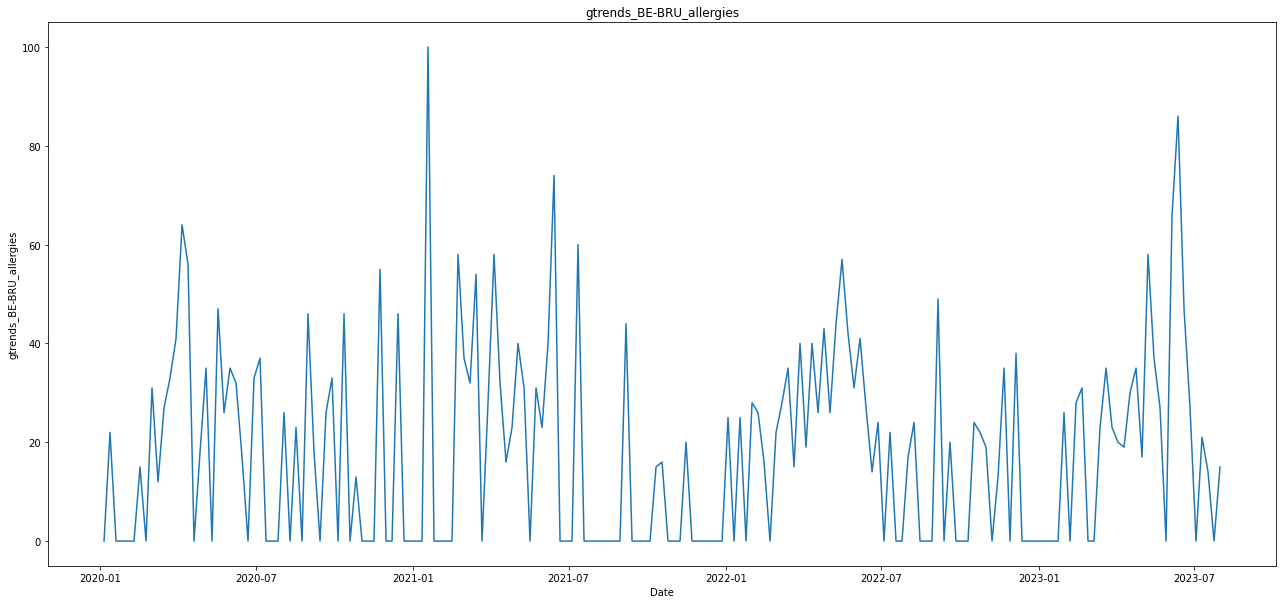

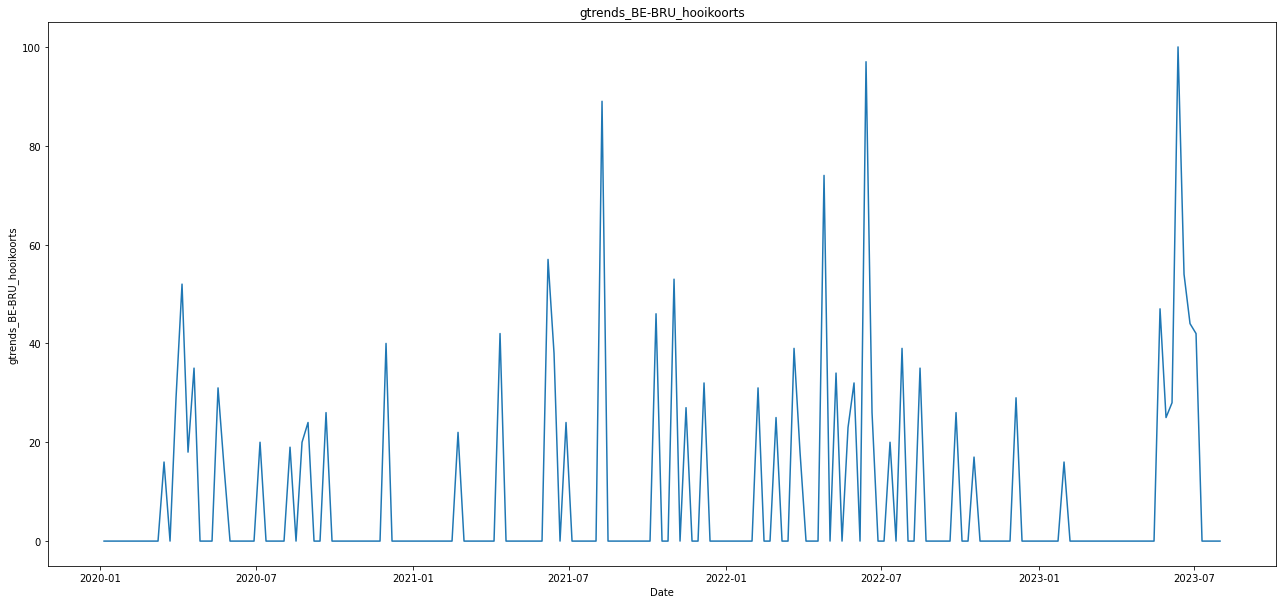

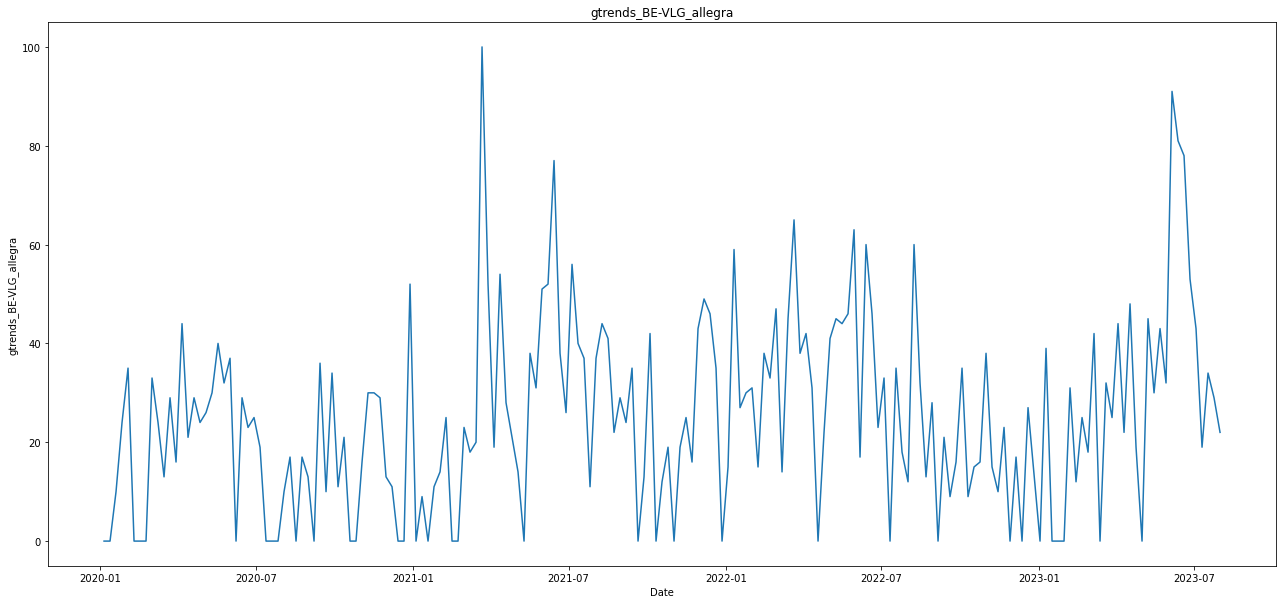

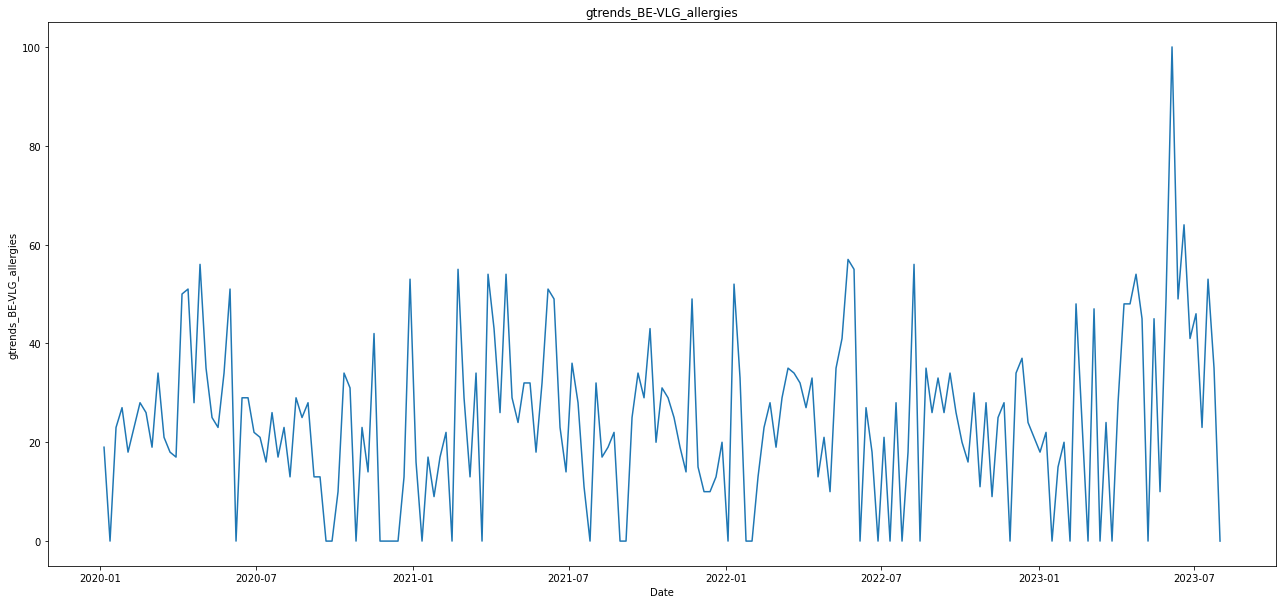

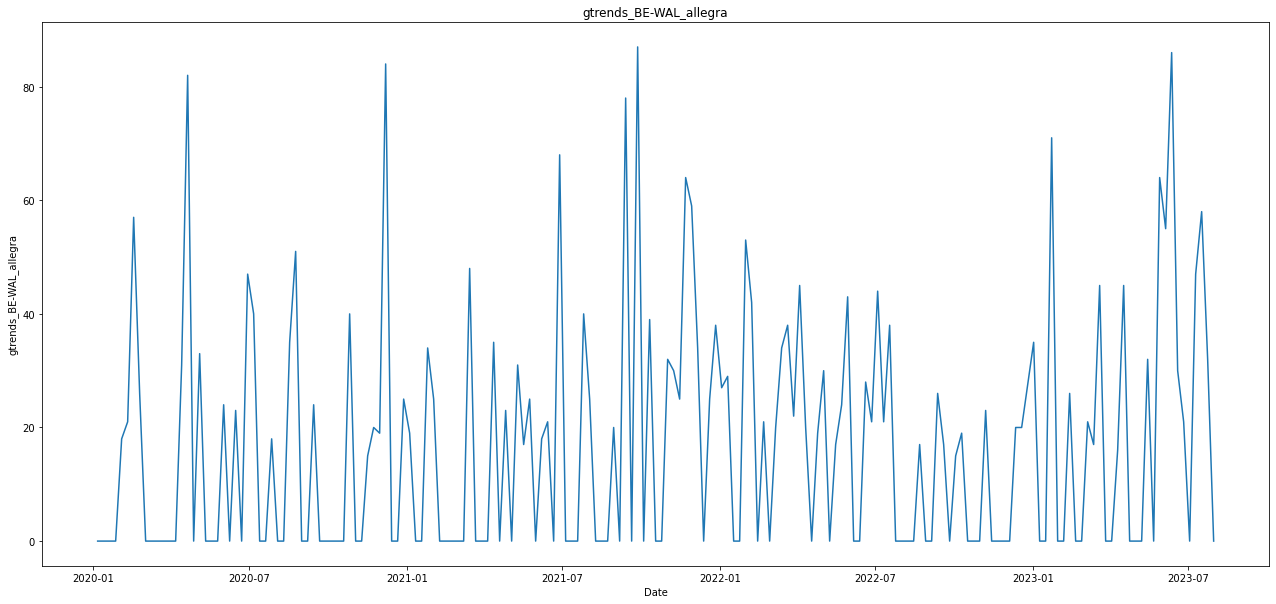

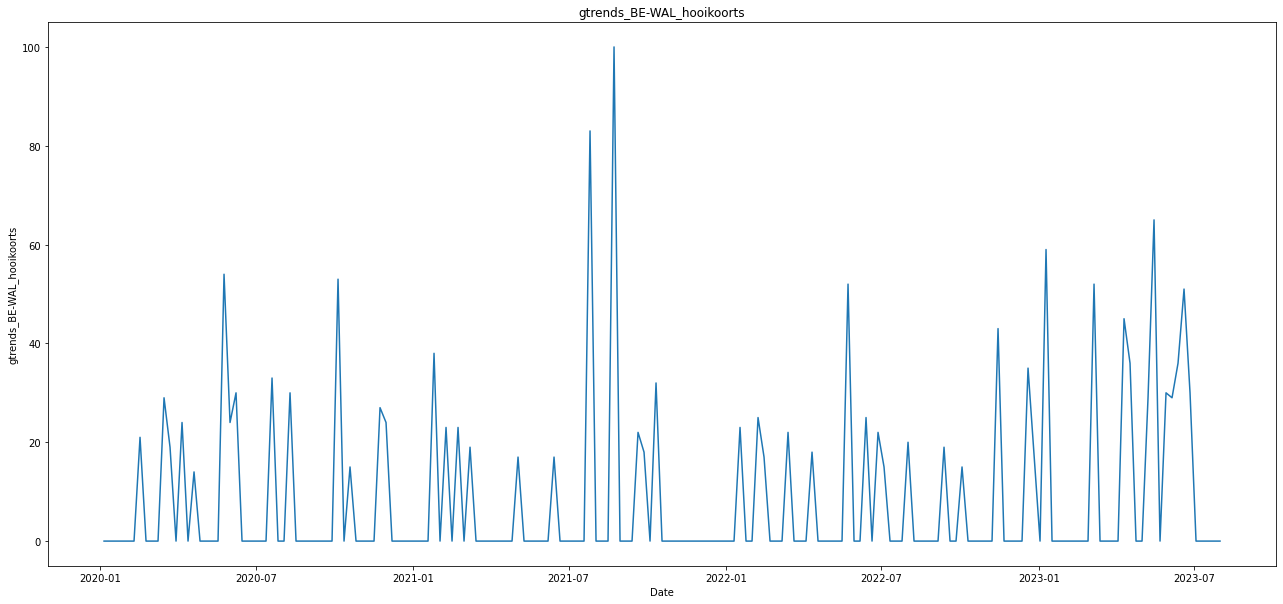

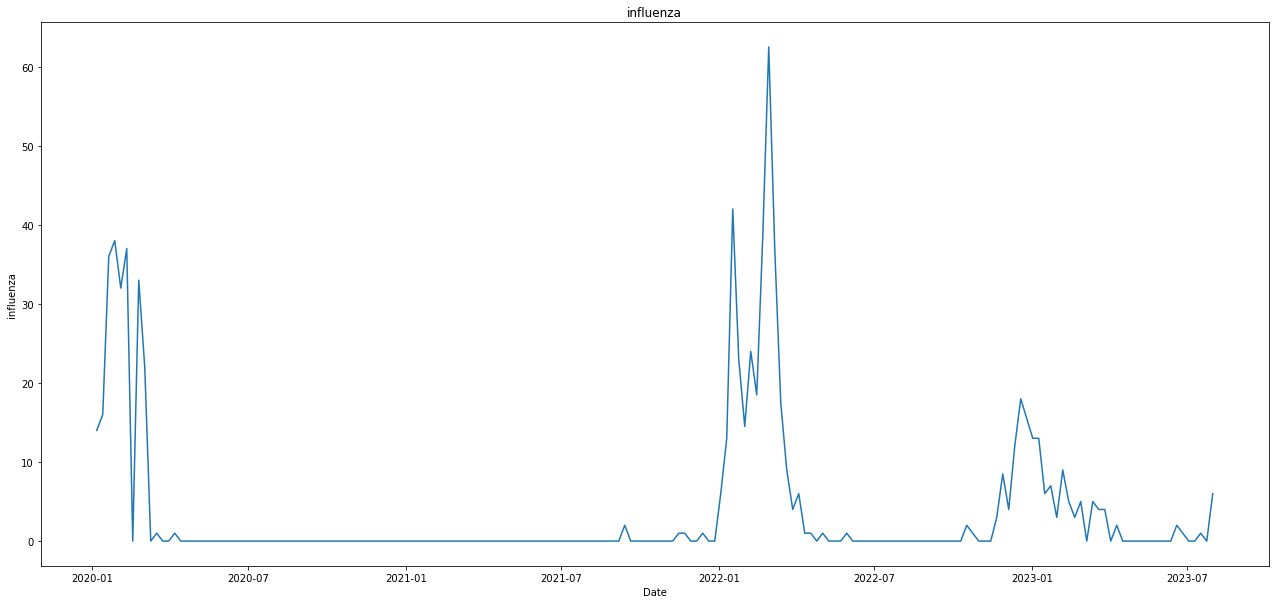

In [18]:
for key in tseries.keys():
    plt.figure(figsize=(22,10))
    plt.plot(tseries[key])
    plt.title(str(key))
    plt.xlabel("Date")
    plt.ylabel(str(key))
    plt.show()


Podemos ver una caída brusca de las ventas en los meses del inicio del covid en europa, coincidiendo con los confinamientos, puede ser buena idea obviar estos datos y no tenerlos en cuanta para entrenar. También podemos ver una estacionalidad clara de los datos, habiendo mayores ventas en la primera mitad del año y más bajas en la segunda mitad.

Sobre las variables de google trends, como por ejemplo temperatura o humedad medias de Bruselas, podemos ver también una estacionalidad clara, aunque a simple vista no se ven tendencia clara en esas variables.

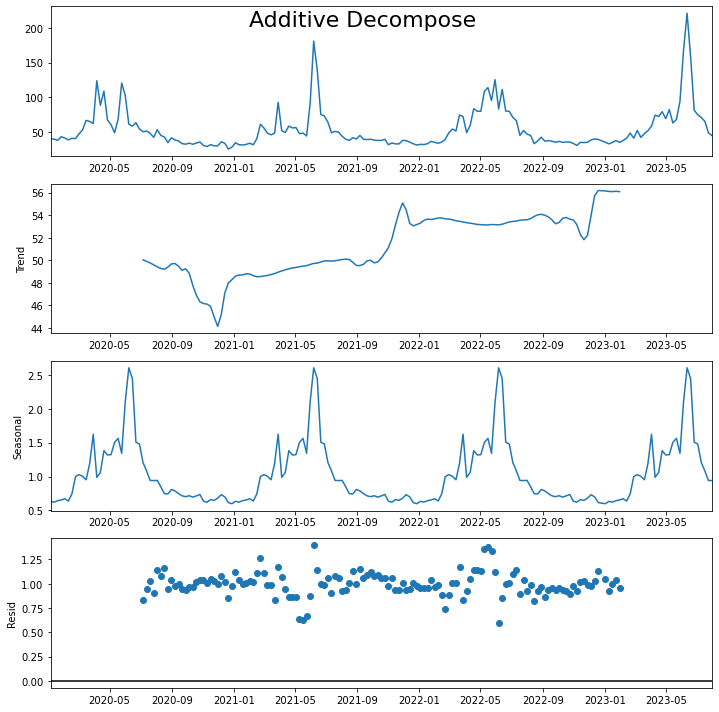

In [19]:
df_stl = pd.DataFrame({'data': df_study['sales_city1'].values}, index=pd.to_datetime(df_study['date']))
# Asegúrate de que 'sales_city1' contiene valores numéricos
# Si no lo son, conviértelos a números

df_stl.sort_index(inplace=True)

#df_stl= df_stl.asfreq('7D')
# Aplica seasonal_decompose a la serie temporal especificando la frecuencia
result = seasonal_decompose(df_stl, model='multiplicative', period=52)  # Ajusta la frecuencia adecuada

# Grafica el resultado
#result.plot()

plt.rcParams.update({'figure.figsize': (10,10)})
result.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [20]:
### Tengo dudas de cual sería el period adecuado, sería 52 porque tenemos datos semanales, o sería otro?

# Modelos iniciales de regresión

El objetivo de estos modelos es ver que variables son más significativas a la hora de predecir la variable objetivo y ver que modelos funcionan mejor con estos datos, posteriormente hacemos un modelo de ensembling usando los mejores modelos.

## Random Forest

In [21]:
X = df_study.drop(['date', 'sales_city1'], axis=1)  
y = df_study['sales_city1']

#X = X.fillna(9999999)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crea un modelo de Random Forest para regresión
rf_model = RandomForestRegressor(n_estimators=300, random_state=42)  # Puedes ajustar los hiperparámetros según sea necesario

# Entrena el modelo en el conjunto de entrenamiento
rf_model.fit(X_train, y_train)

# Realiza predicciones en el conjunto de prueba
y_pred = rf_model.predict(X_test)

# Calcula la métrica de rendimiento (en este caso, el error cuadrático medio)
mse = mean_squared_error(y_test, y_pred)
print(f"Error Cuadrático Medio del modelo de Random Forest: {mse:.2f}")

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE del modelo Ridge: {mape:.2f}%")

Error Cuadrático Medio del modelo de Random Forest: 90.23
MAPE del modelo Ridge: 10.87%


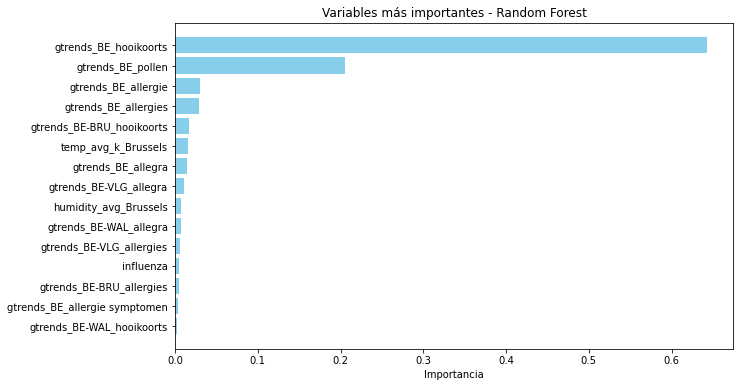

In [22]:
importances = rf_model.feature_importances_

# Obtener los nombres de las características (nombres de las columnas)
feature_names = X.columns  # Reemplaza X con tu conjunto de datos

# Crear un dataframe con las características y sus importancias
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Ordenar las características por su importancia
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Graficar las características más importantes
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importancia')
plt.title('Variables más importantes - Random Forest')
plt.gca().invert_yaxis()  # Invertir para tener la característica más importante arriba
plt.show()

Viendo esto podríamos plantearnos eliminar más variables que tienen poca importancia.

In [23]:
# Calcula el R cuadrado (R²)
r2 = r2_score(y_test, y_pred)

# Número de observaciones (n) y número de predictores (p)
n = len(y_test)
p = X_test.shape[1]  # Número de características

# Calcula el R cuadrado ajustado (R² ajustado)
r2_ajustado = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print(f"R²: {r2:.2f}")
print(f"R² Ajustado: {r2_ajustado:.2f}")

R²: 0.90
R² Ajustado: 0.83


Cómo vemos el modelo ajusta bastante bien.

## LGBM

In [24]:
# Crea un modelo de LightGBM para regresión
lgb_model = lgb.LGBMRegressor(n_estimators=300, random_state=42)  # Puedes ajustar los hiperparámetros según sea necesario

# Entrena el modelo en el conjunto de entrenamiento
lgb_model.fit(X_train, y_train)

# Realiza predicciones en el conjunto de prueba
y_pred = lgb_model.predict(X_test)

# Calcula la métrica de rendimiento (en este caso, el error cuadrático medio)
mse = mean_squared_error(y_test, y_pred)
print(f"Error Cuadrático Medio del modelo de LightGBM: {mse:.2f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 419
[LightGBM] [Info] Number of data points in the train set: 148, number of used features: 15
[LightGBM] [Info] Start training from score 52.034230
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [25]:
# Calcula el R cuadrado (R²)
r2 = r2_score(y_test, y_pred)

# Número de observaciones (n) y número de predictores (p)
n = len(y_test)
p = X_test.shape[1]  # Número de características

# Calcula el R cuadrado ajustado (R² ajustado)
r2_ajustado = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print(f"R²: {r2:.2f}")
print(f"R² Ajustado: {r2_ajustado:.2f}")

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE del modelo LGBM: {mape:.2f}%")

R²: 0.85
R² Ajustado: 0.75
MAPE del modelo LGBM: 14.50%


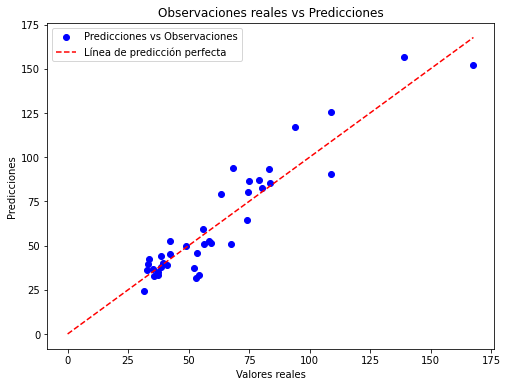

In [26]:
import matplotlib.pyplot as plt

# Graficar observaciones reales vs predicciones
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicciones vs Observaciones')

# Agregar etiquetas y título
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Observaciones reales vs Predicciones')

# Agregar línea diagonal (para representar predicciones perfectas)
max_value = max(max(y_test), max(y_pred))
plt.plot([0, max_value], [0, max_value], color='red', linestyle='--', label='Línea de predicción perfecta')

plt.legend()
plt.show()

## XGBoost

In [27]:
# Crea un modelo de XGBoost para regresión
xgb_model = xgb.XGBRegressor(n_estimators=300, random_state=42)  # Puedes ajustar los hiperparámetros según sea necesario

# Entrena el modelo en el conjunto de entrenamiento
xgb_model.fit(X_train, y_train)

# Realiza predicciones en el conjunto de prueba
y_pred = xgb_model.predict(X_test)

# Calcula la métrica de rendimiento (en este caso, el error cuadrático medio)
mse = mean_squared_error(y_test, y_pred)
print(f"Error Cuadrático Medio del modelo de XGBoost: {mse:.2f}")

Error Cuadrático Medio del modelo de XGBoost: 148.82


In [28]:
# Calcula el R cuadrado (R²)
r2 = r2_score(y_test, y_pred)

# Número de observaciones (n) y número de predictores (p)
n = len(y_test)
p = X_test.shape[1]  # Número de características

# Calcula el R cuadrado ajustado (R² ajustado)
r2_ajustado = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print(f"R²: {r2:.2f}")
print(f"R² Ajustado: {r2_ajustado:.2f}")

R²: 0.83
R² Ajustado: 0.72


## SVR

In [29]:
# Crear un modelo de Support Vector Regressor (SVR)
svr = SVR(kernel='poly')  # Se puede elegir el tipo de kernel apropiado para tu problema

# Entrenar el modelo con los datos de entrenamiento
svr.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = svr.predict(X_test)

# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, y_pred)
print(f"Error Cuadrático Medio del modelo SVR: {mse:.2f}")

Error Cuadrático Medio del modelo SVR: 573.17


In [30]:
# Calcula el R cuadrado (R²)
r2 = r2_score(y_test, y_pred)

# Número de observaciones (n) y número de predictores (p)
n = len(y_test)
p = X_test.shape[1]  # Número de características

# Calcula el R cuadrado ajustado (R² ajustado)
r2_ajustado = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print(f"R²: {r2:.2f}")
print(f"R² Ajustado: {r2_ajustado:.2f}")

R²: 0.36
R² Ajustado: -0.08


## Lasso

In [31]:
# Crear un modelo de Lasso Regression
lasso = Lasso(alpha=1.0)  # Puedes ajustar el hiperparámetro alpha según sea necesario

# Entrenar el modelo con los datos de entrenamiento
lasso.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = lasso.predict(X_test)

# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, y_pred)
print(f"Error Cuadrático Medio del modelo Lasso: {mse:.2f}")

Error Cuadrático Medio del modelo Lasso: 58.06


In [32]:
# Calcula el R cuadrado (R²)
r2 = r2_score(y_test, y_pred)

# Número de observaciones (n) y número de predictores (p)
n = len(y_test)
p = X_test.shape[1]  # Número de características

# Calcula el R cuadrado ajustado (R² ajustado)
r2_ajustado = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print(f"R²: {r2:.2f}")
print(f"R² Ajustado: {r2_ajustado:.2f}")

R²: 0.94
R² Ajustado: 0.89


## Ridge

In [33]:
# Crear un modelo de Regresión Ridge
ridge = Ridge(alpha=1.0)  # Puedes ajustar el hiperparámetro alpha según sea necesario

# Entrenar el modelo con los datos de entrenamiento
ridge.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = ridge.predict(X_test)

# Calcular el error cuadrático medio
mse = mean_squared_error(y_test, y_pred)
print(f"Error Cuadrático Medio del modelo Ridge: {mse:.2f}")

Error Cuadrático Medio del modelo Ridge: 57.00


In [34]:
# Calcula el R cuadrado (R²)
r2 = r2_score(y_test, y_pred)

# Número de observaciones (n) y número de predictores (p)
n = len(y_test)
p = X_test.shape[1]  # Número de características

# Calcula el R cuadrado ajustado (R² ajustado)
r2_ajustado = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print(f"R²: {r2:.2f}")
print(f"R² Ajustado: {r2_ajustado:.2f}")

R²: 0.94
R² Ajustado: 0.89


Los modelos que mejor han funcionado han sido Random Forest, regresión Lasso, Ridge, LGBM y XGBoost.
SVR ha funcionado muy mal.


Ahora vamos a probar Prophet

## Prophet

In [35]:
%%time
m = Prophet()
prophet_input = pd.DataFrame()
prophet_input['ds'] = tseries['sales_city1'].index
prophet_input['y'] = tseries['sales_city1'].values


m.fit(prophet_input)

20:15:55 - cmdstanpy - INFO - Chain [1] start processing
20:15:55 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 62.5 ms
Wall time: 810 ms


In [36]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
546,2024-07-26,57.810454,37.574296,80.347599
547,2024-07-27,56.891575,35.025337,76.689997
548,2024-07-28,55.933120,34.582243,75.632157
549,2024-07-29,54.952707,34.445795,75.232092
550,2024-07-30,53.968545,32.168318,73.974731


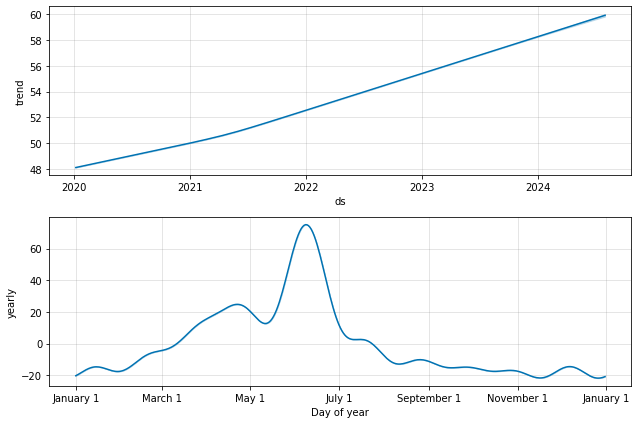

In [37]:
fig2 = m.plot_components(forecast)

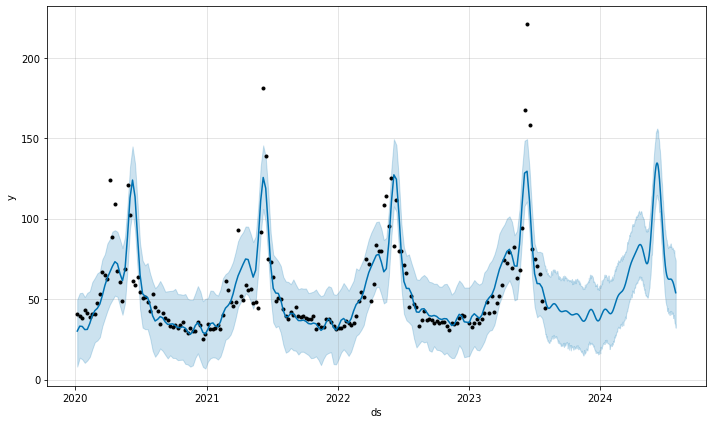

In [38]:
fig1 = m.plot(forecast)

In [39]:
# Run test
adf_result = adfuller(tseries['sales_city1'])

# Parse test statistic and p value
print(f'ADF Test Statistic {adf_result[0]:.2f}')
print(f'P Value {adf_result[1]:.2f}')
if adf_result[1] > 0.05:
    print('Time series is not stationary. Time-dependent structure such as seasonality exists.')
else:
    print('Time series is stationary, p value < 0.05.')

ADF Test Statistic -3.62
P Value 0.01
Time series is stationary, p value < 0.05.


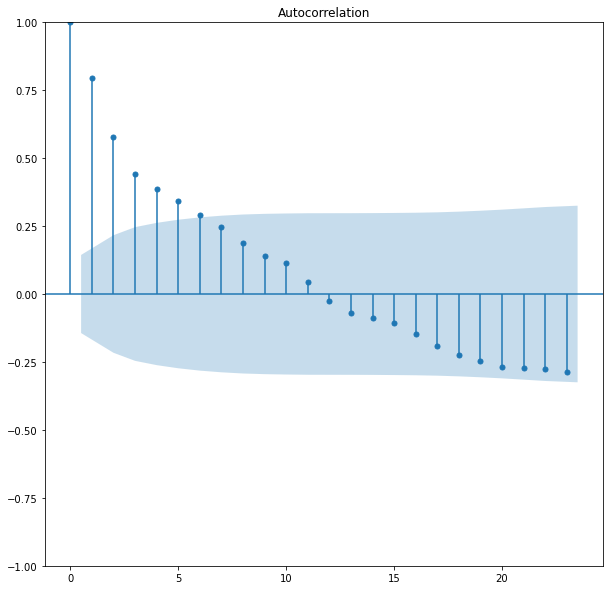

In [40]:
#Autocorrelation

plot_acf(tseries['sales_city1'])
plt.show()

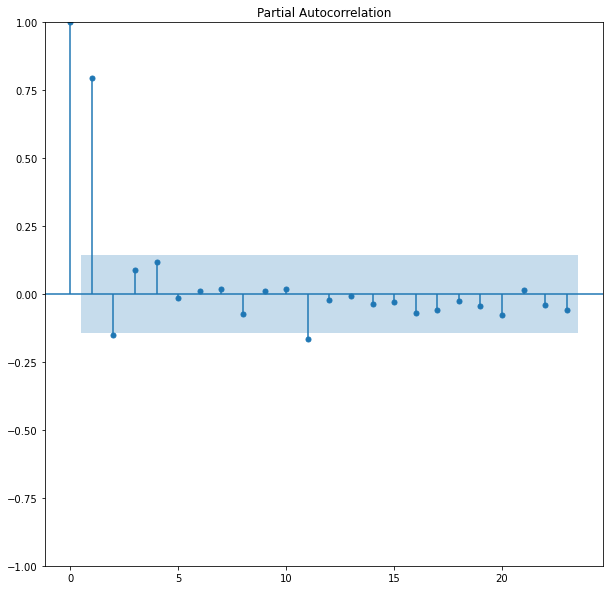

In [41]:
# Partial Autocorrelation

plot_pacf(tseries['sales_city1'], method='ywm')
plt.show()

Window-based change point detection is a pretty nifty method to find where a signal changes.

Imagine two windows sliding along the time series, checking out the properties within each window (like the mean).

What we’re looking for is how similar or different these properties are, and that’s where the discrepancy measure comes in.

Think of the discrepancy as a way to measure how much difference splitting the signal at a certain point would make.

If the properties of the windows are similar, the discrepancy will be low. Else, it will be high, and that’s when we suspect a change point occurred.

One issue is that the choice of window length can have a significant impact on the results.

Too small, and you might miss some change points; too large, and it could ignore important changes.

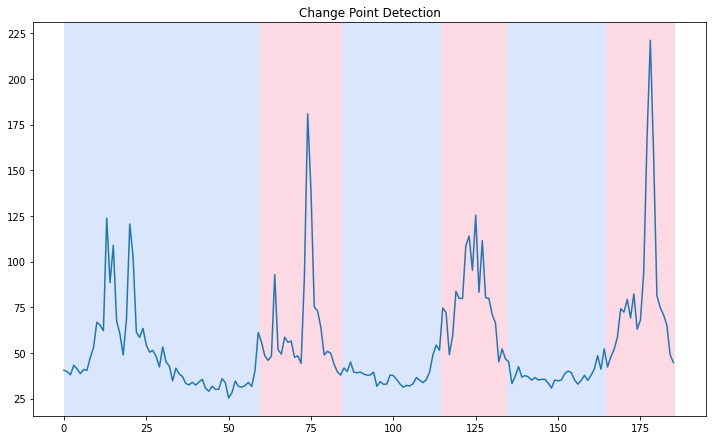

In [42]:
# Model Inputs
points = np.array(tseries['sales_city1'])


algo = rpt.Window(model="l2", width=30)
algo.fit(points)
result = algo.predict(n_bkps=5)


rpt.show.display(points, result, figsize=(10, 6))
plt.title('Change Point Detection')
plt.show()

(<Figure size 720x144 with 1 Axes>, [<AxesSubplot:>])

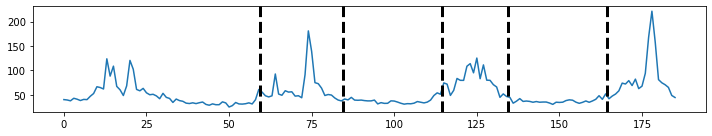

In [43]:
rpt.display(points, [], result)

In [44]:
#Hacer prueba de dickey fuller y el resto de tests en todas las series temporales

# ARIMA

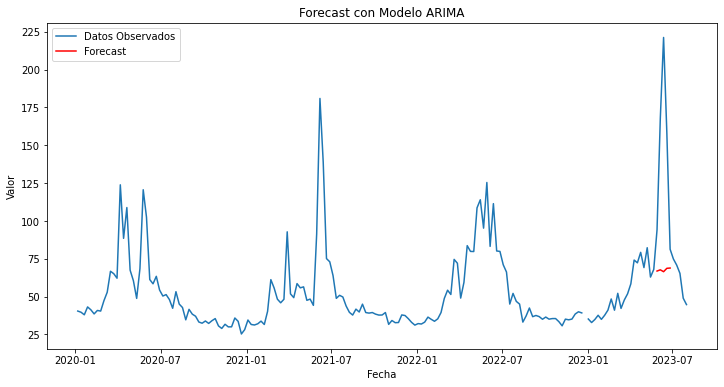

In [235]:
from statsmodels.tsa.arima.model import ARIMA

# Fijamos fechas para definir los parámetros del Ridge

#ts_data_train = ts_data[:'2023-05-22']
#ts_data_test = ts_data['2023-05-27':]
#hasta '2023-06-26'

#Para predicciones finales:
#    ts_data_train = ts_data[:'2023-06-26']
#    ts_data_test = ts_data['2023-07-03':]
#    '2023-07-31'
ts_data = tseries['sales_city1']
ts_data = ts_data.asfreq('W-MON')

ts_data_train = ts_data[:'2023-05-22']
ts_data_test = ts_data['2023-05-27':'2023-06-26']

# Ajustamos el modelo ARIMA a la serie temporal
model = ARIMA(ts_data_train, order=(2, 1, 5))  # Parámetros p, d, q del modelo ARIMA
arima_results = model.fit()

# Realizamos el pronóstico (forecast) de 30 periodos hacia adelante
forecast_arima = arima_results.forecast(steps=5)

# Visualizamos el pronóstico
plt.figure(figsize=(12, 6))
plt.plot(ts_data.index, ts_data.values, label='Datos Observados')
plt.plot(forecast_arima.index, forecast_arima, label='Forecast', color='red')
plt.title('Forecast con Modelo ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [237]:
predicted_values = forecast_arima
actual_values = ts_data_test
# Calcular las métricas de bondad de ajuste
mse = mean_squared_error(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

# Mostrar las métricas
print(f'Error Cuadrático Medio (MSE): {mse:.2f}')
print(f'Error Absoluto Medio (MAE): {mae:.2f}')
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}')
print(f'Error Porcentual Absoluto Medio (MAPE): {mape:.2f}%')

Error Cuadrático Medio (MSE): 8563.33
Error Absoluto Medio (MAE): 76.74
Raíz del Error Cuadrático Medio (RMSE): 92.54
Error Porcentual Absoluto Medio (MAPE): 46.06%


# SARIMA

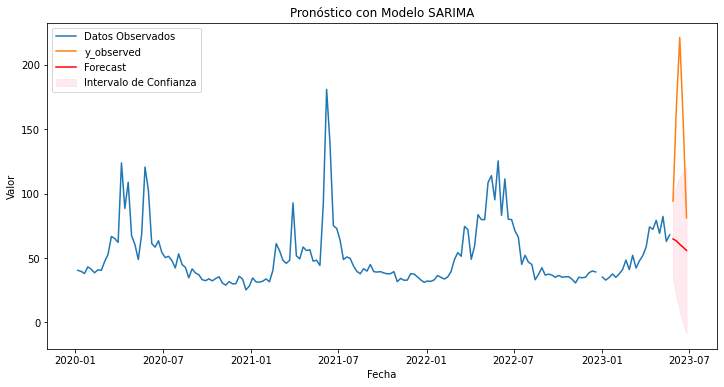

In [240]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


model = SARIMAX(ts_data_train, order=(1, 0, 0), seasonal_order=(1, 0, 1, 12))
sarima_results = model.fit()

# Realizar pronóstico con el modelo SARIMA
#forecast_sarima = sarima_results.get_forecast(steps=3)  # Pronóstico de 50 periodos hacia adelante

forecast_sarima = sarima_results.get_prediction(start=pd.to_datetime('2023-05-29'),end=pd.to_datetime('2023-06-26'), dynamic=False)

# Obtener el intervalo de confianza del pronóstico
forecast_conf_int = forecast_sarima.conf_int()

# Visualizar el pronóstico y el intervalo de confianza
plt.figure(figsize=(12, 6))
plt.plot(ts_data_train.index, ts_data_train.values, label='Datos Observados')
plt.plot(ts_data_test.index, ts_data_test.values, label='y_observed')
plt.plot(forecast_sarima.predicted_mean.index, forecast_sarima.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Intervalo de Confianza')
plt.title('Pronóstico con Modelo SARIMA')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [241]:
predicted_values = forecast_sarima.predicted_mean
actual_values = ts_data_test
# Calcular las métricas de bondad de ajuste
mse = mean_squared_error(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

# Mostrar las métricas
print(f'Error Cuadrático Medio (MSE): {mse:.2f}')
print(f'Error Absoluto Medio (MAE): {mae:.2f}')
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}')
print(f'Error Porcentual Absoluto Medio (MAPE): {mape:.2f}%')

Error Cuadrático Medio (MSE): 9619.54
Error Absoluto Medio (MAE): 83.86
Raíz del Error Cuadrático Medio (RMSE): 98.08
Error Porcentual Absoluto Medio (MAPE): 52.05%


# XGBOOST

In [216]:
from numpy import nan 


C:\Users\tomas\AppData\Local\Temp\ipykernel_24064\2595427198.py:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data_xg['weekofyear'] = data_xg['fecha'].dt.weekofyear


Error Cuadrático Medio (MSE): 6396.35


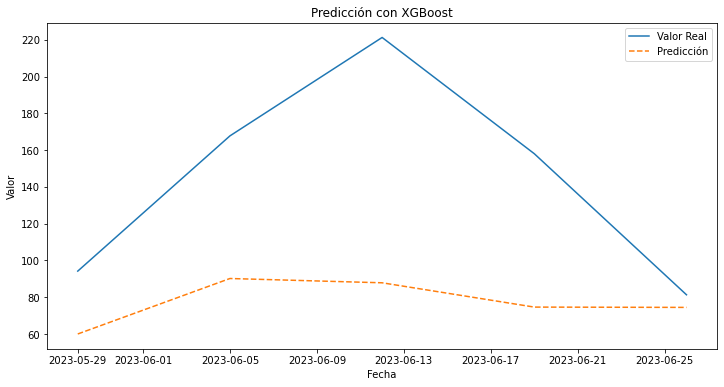

In [268]:
# Asegúrate de tener la columna 'fecha' como índice y ordena los datos por fecha si es necesario

data_xg = df_study.copy()

data_xg['fecha'] = pd.to_datetime(data_xg['date'])
data_xg = data_xg.set_index('fecha').sort_index()


# Preparar características (lag features) y variable objetivo para el modelo
lags = 5  # Número de retrasos pasados a considerar como características
for i in range(1, lags + 1):
    data_xg[f'lag_{i}'] = data_xg['sales_city1'].shift(i)

    data_xg.dropna(inplace=True)  # Eliminar filas con valores NaN generados por los retrasos

data_xg.dropna(inplace=True)  # Eliminar filas con valores NaN generados por los retrasos

data_xg['fecha'] = data_xg.index
data_xg['quarter'] = data_xg['fecha'].dt.quarter
data_xg['month'] = data_xg['fecha'].dt.month
data_xg['year'] = data_xg['fecha'].dt.year
data_xg['dayofyear'] = data_xg['fecha'].dt.dayofyear
data_xg['dayofmonth'] = data_xg['fecha'].dt.day
data_xg['weekofyear'] = data_xg['fecha'].dt.weekofyear

ts_data_xg_train = data_xg[:'2023-05-22']
ts_data_xg_test = data_xg['2023-05-27':'2023-06-26']


    
ts_data_xg_test.iloc[1, 17] = nan
ts_data_xg_test.iloc[2, 17:19] = nan
ts_data_xg_test.iloc[3, 17:20] = nan
ts_data_xg_test.iloc[4, 17:21] = nan

# Dividir datos en características (X) y variable objetivo (y)
X_train, y_train = ts_data_xg_train[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5','quarter','month','year',
       'dayofyear','dayofmonth','weekofyear']], ts_data_xg_train['sales_city1']
X_test, y_test = ts_data_xg_test[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5','quarter','month','year',
       'dayofyear','dayofmonth','weekofyear']], ts_data_xg_test['sales_city1']

# Inicializar y entrenar el modelo XGBoost
model = xgb.XGBRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_xg = model.predict(X_test)

# Calcular el error en el conjunto de prueba
mse = mean_squared_error(y_test, y_pred_xg)
print(f'Error Cuadrático Medio (MSE): {mse:.2f}')

# Visualizar las predicciones vs valores reales
plt.figure(figsize=(12, 6))
plt.plot(ts_data_xg_test.index, y_test, label='Valor Real')
plt.plot(ts_data_xg_test.index, y_pred_xg, label='Predicción', linestyle='dashed')
plt.title('Predicción con XGBoost')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [269]:
predicted_values = y_pred_xg
actual_values = ts_data_test
# Calcular las métricas de bondad de ajuste
mse = mean_squared_error(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

# Mostrar las métricas
print(f'Error Cuadrático Medio (MSE): {mse:.2f}')
print(f'Error Absoluto Medio (MAE): {mae:.2f}')
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}')
print(f'Error Porcentual Absoluto Medio (MAPE): {mape:.2f}%')

Error Cuadrático Medio (MSE): 6396.35
Error Absoluto Medio (MAE): 67.08
Raíz del Error Cuadrático Medio (RMSE): 79.98
Error Porcentual Absoluto Medio (MAPE): 40.81%


# LGBM

In [270]:
# Crea un modelo de LightGBM para regresión
lgb_model = lgb.LGBMRegressor(n_estimators=300, random_state=42)  # Puedes ajustar los hiperparámetros según sea necesario

# Entrena el modelo en el conjunto de entrenamiento
lgb_model.fit(X_train, y_train)

# Realiza predicciones en el conjunto de prueba
y_pred_lgb = lgb_model.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 438
[LightGBM] [Info] Number of data points in the train set: 161, number of used features: 11
[LightGBM] [Info] Start training from score 51.076401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

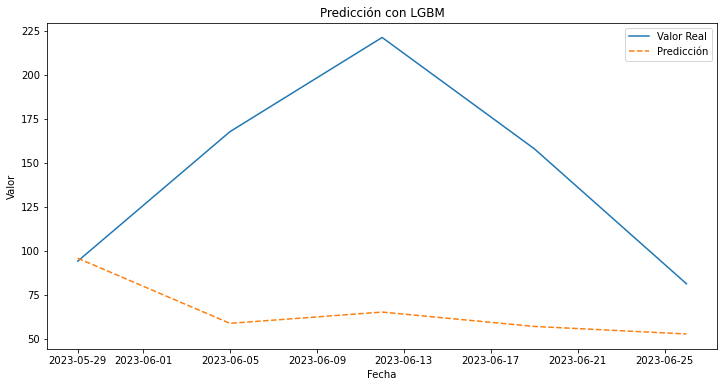

In [271]:
# Visualizar las predicciones vs valores reales
plt.figure(figsize=(12, 6))
plt.plot(ts_data_xg_test.index, y_test, label='Valor Real')
plt.plot(ts_data_xg_test.index, y_pred_lgb, label='Predicción', linestyle='dashed')
plt.title('Predicción con LGBM')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [272]:
predicted_values = y_pred_lgb
actual_values = ts_data_test
# Calcular las métricas de bondad de ajuste
mse = mean_squared_error(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

# Mostrar las métricas
print(f'Error Cuadrático Medio (MSE): {mse:.2f}')
print(f'Error Absoluto Medio (MAE): {mae:.2f}')
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}')
print(f'Error Porcentual Absoluto Medio (MAPE): {mape:.2f}%')

Error Cuadrático Medio (MSE): 9437.73
Error Absoluto Medio (MAE): 79.19
Raíz del Error Cuadrático Medio (RMSE): 97.15
Error Porcentual Absoluto Medio (MAPE): 47.22%


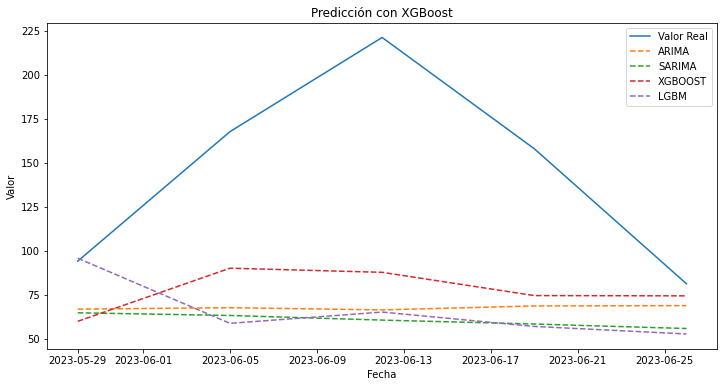

In [273]:
# Visualizar las predicciones vs valores reales
plt.figure(figsize=(12, 6))
plt.plot(ts_data_xg_test.index, y_test, label='Valor Real')
plt.plot(ts_data_xg_test.index, forecast_arima, label='ARIMA', linestyle='dashed')
#plt.plot(ts_data_xg_test.index, forecast_sarima.values, label='Predicción', linestyle='dashed')
plt.plot(forecast_sarima.predicted_mean.index, forecast_sarima.predicted_mean, label='SARIMA', linestyle='dashed')
plt.plot(ts_data_xg_test.index, y_pred_xg, label='XGBOOST', linestyle='dashed')
plt.plot(ts_data_xg_test.index, y_pred_lgb, label='LGBM', linestyle='dashed')

plt.title('Predicción con XGBoost')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [274]:
ensemb_inp = pd.DataFrame()
ensemb_inp['ARIMA'] = forecast_arima
ensemb_inp['SARIMA'] = forecast_sarima.predicted_mean
ensemb_inp['XGBOOST'] = y_pred_xg
ensemb_inp['LGBM'] = y_pred_lgb
ensemb_inp

,ARIMA,SARIMA,XGBOOST,LGBM
2023-05-29,66.903411,64.833572,59.995007,95.818750
2023-06-05,67.725003,63.299851,90.158195,58.837718
2023-06-12,66.480958,60.679386,87.827248,65.238511
2023-06-19,68.712938,58.449729,74.611198,57.084083
2023-06-26,68.893881,55.892612,74.446899,52.799692


Aplha: 0.001
Error Cuadrático Medio (MSE): 734.06
Error Absoluto Medio (MAE): 23.06
Raíz del Error Cuadrático Medio (RMSE): 27.09
Error Porcentual Absoluto Medio (MAPE): 18.58%


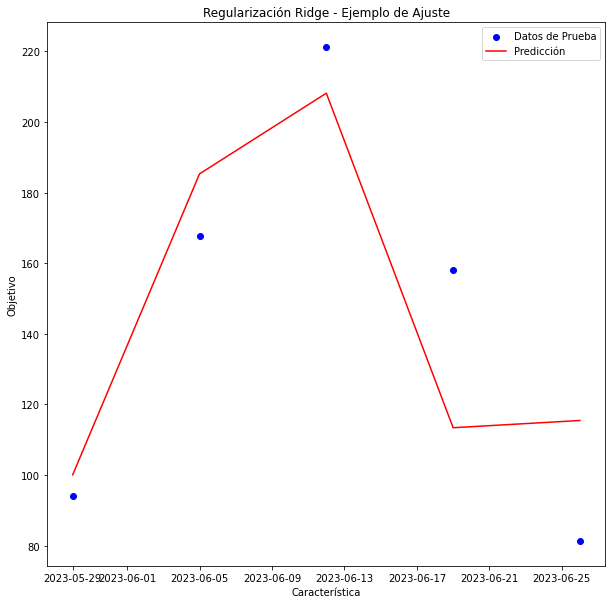

------------
Aplha: 0.01
Error Cuadrático Medio (MSE): 734.06
Error Absoluto Medio (MAE): 23.07
Raíz del Error Cuadrático Medio (RMSE): 27.09
Error Porcentual Absoluto Medio (MAPE): 18.58%


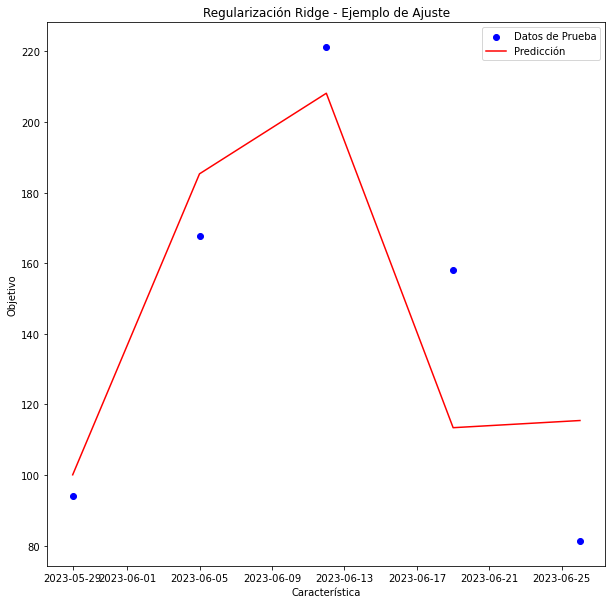

------------
Aplha: 0.1
Error Cuadrático Medio (MSE): 734.07
Error Absoluto Medio (MAE): 23.11
Raíz del Error Cuadrático Medio (RMSE): 27.09
Error Porcentual Absoluto Medio (MAPE): 18.59%


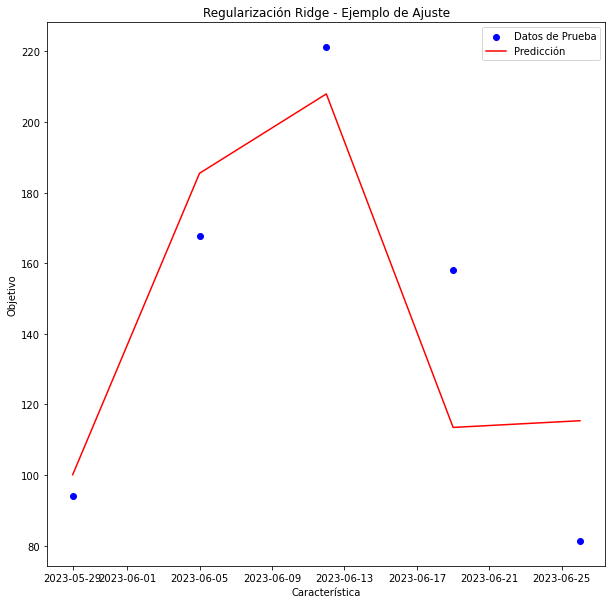

------------
Aplha: 0.5
Error Cuadrático Medio (MSE): 734.42
Error Absoluto Medio (MAE): 23.30
Raíz del Error Cuadrático Medio (RMSE): 27.10
Error Porcentual Absoluto Medio (MAPE): 18.66%


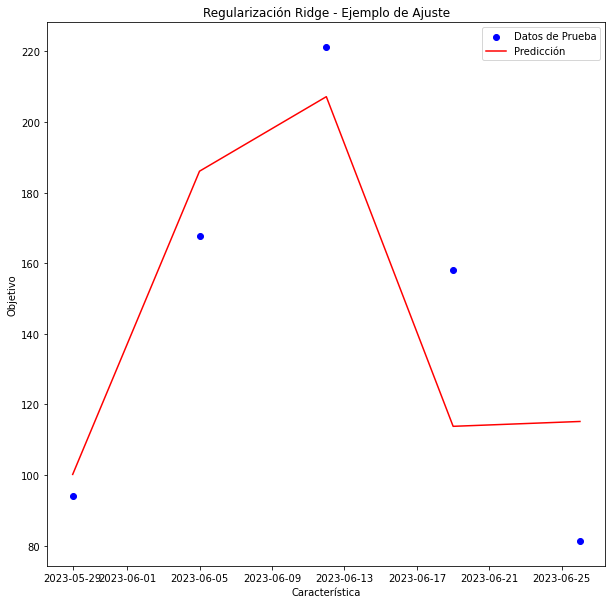

------------
Aplha: 1
Error Cuadrático Medio (MSE): 735.30
Error Absoluto Medio (MAE): 23.51
Raíz del Error Cuadrático Medio (RMSE): 27.12
Error Porcentual Absoluto Medio (MAPE): 18.74%


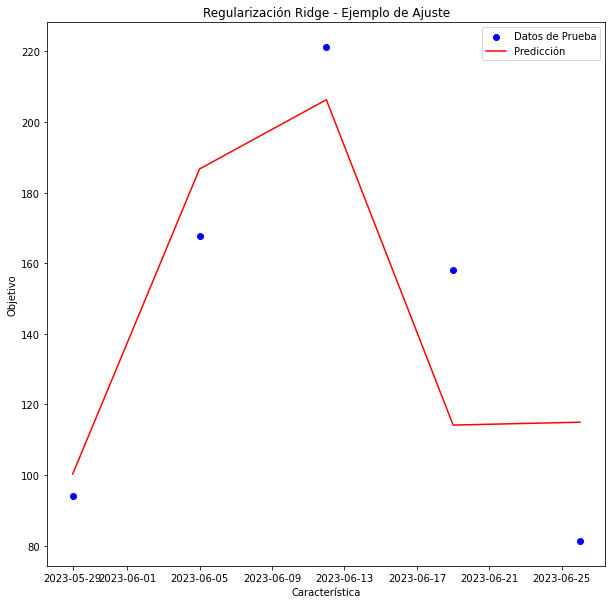

------------
Aplha: 2
Error Cuadrático Medio (MSE): 737.84
Error Absoluto Medio (MAE): 23.84
Raíz del Error Cuadrático Medio (RMSE): 27.16
Error Porcentual Absoluto Medio (MAPE): 18.87%


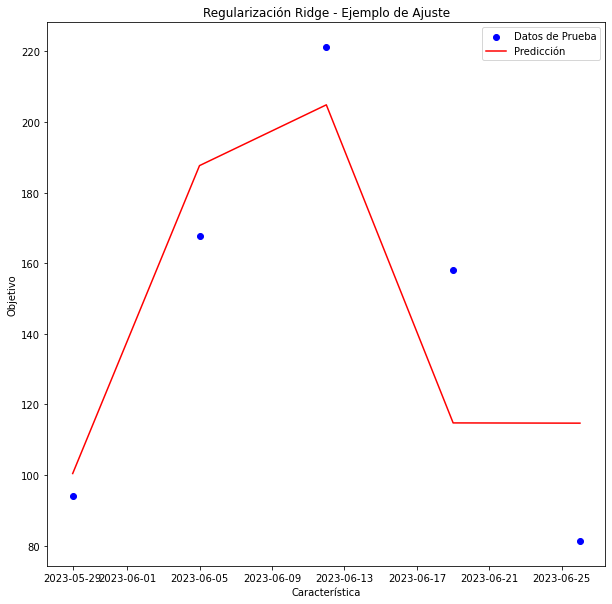

------------


In [281]:
from sklearn.linear_model import Ridge
for alpha in (0.001, 0.01, 0.1, 0.5, 1, 2):
    
    print('Aplha:', alpha)
    

    # Inicializar el modelo Ridge
    ridge = Ridge(alpha=alpha, fit_intercept=False)

    # Entrenar el modelo
    ridge.fit(ensemb_inp, y_test)

    # Realizar predicciones en el conjunto de prueba
    y_pred_ridge = ridge.predict(ensemb_inp)

    # Calcular el error en el conjunto de prueba
    mse = mean_squared_error(y_test, y_pred_ridge)
    print(f'Error Cuadrático Medio (MSE): {mse:.2f}')

    mae = mean_absolute_error(y_test, y_pred_ridge)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred_ridge) / y_test)) * 100

    # Mostrar las métricas
    print(f'Error Absoluto Medio (MAE): {mae:.2f}')
    print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}')
    print(f'Error Porcentual Absoluto Medio (MAPE): {mape:.2f}%')


    # Visualizar el ajuste del modelo
    plt.scatter(ts_data_xg_test.index, y_test, color='blue', label='Datos de Prueba')
    plt.plot(ts_data_xg_test.index, y_pred_ridge, color='red', label='Predicción')
    plt.title('Regularización Ridge - Ejemplo de Ajuste')
    plt.xlabel('Característica')
    plt.ylabel('Objetivo')
    plt.legend()
    plt.show()
    print('------------')

In [276]:
# Read out attributes
ridge.coef_         # dense np.array
#ridge.sparse_coef_  # sparse matrix

#ridge.intercept_   

array([-2.40708112, -5.20675011,  5.84253189,  2.59208712])

In [277]:
ridge.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': False,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

from pyramid.arima import auto_arima
stepwise_model = auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())